In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS 
from global_config import RANDOM_SEED, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)
print(FOLDER_MODELS)
print(IMAGE_SIZE)
print(RANDOM_SEED)
print(USER_IDS)

../data/pybossa/pybossa_images.pkl
../data/pybossa/pybossa_mrks.pkl
../models/autoencoders_requirements/
(224, 224)
42
1_2_6


In [3]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'
FILE_MERGED_MODEL = f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5290 - accuracy: 0.7171 - precision: 0.9511 - recall: 0.7176 - f1: 0.8061 - specificity: 0.7237 - negative_predictive_value: 0.2889 - matthews_correlation_coefficient: 0.3194 - val_loss: 0.5394 - val_accuracy: 0.6730 - val_precision: 0.9484 - val_recall: 0.6255 - val_f1: 0.7510 - val_specificity: 0.8719 - val_negative_predictive_value: 0.2630 - val_matthews_correlation_coefficient: 0.3194

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.31941, saving model to ../models/autoencoders_requirements/blurred_2020_03_29-00_35_18.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4691 - accuracy: 0.7345 - precision: 0.9629 - recall: 0.7293 - f1: 0.8204 - specificity: 0.7770 - negative_predictive_value: 0.3026 - matthews_correlation_coefficient: 0.3594 - val_loss: 0.4540 - val_accuracy: 0.7684 - val_precision: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4106 - accuracy: 0.7805 - precision: 0.9739 - recall: 0.7744 - f1: 0.8587 - specificity: 0.8204 - negative_predictive_value: 0.3400 - matthews_correlation_coefficient: 0.4230 - val_loss: 0.3448 - val_accuracy: 0.8300 - val_precision: 0.9228 - val_recall: 0.8297 - val_f1: 0.8716 - val_specificity: 0.6191 - val_negative_predictive_value: 0.3908 - val_matthews_correlation_coefficient: 0.3710

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.39207
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4101 - accuracy: 0.7746 - precision: 0.9712 - recall: 0.7678 - f1: 0.8518 - specificity: 0.8204 - negative_predictive_value: 0.3309 - matthews_correlation_coefficient: 0.4157 - val_loss: 0.4408 - val_accuracy: 0.7528 - val_precision: 0.9493 - val_recall: 0.7158 - val_f1: 0.8137 - val_specificity: 0.8451 - val_negative_predictive_value: 0.3180 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.41923
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3853 - accuracy: 0.7824 - precision: 0.9775 - recall: 0.7690 - f1: 0.8579 - specificity: 0.8373 - negative_predictive_value: 0.3398 - matthews_correlation_coefficient: 0.4350 - val_loss: 0.4151 - val_accuracy: 0.7693 - val_precision: 0.9548 - val_recall: 0.7296 - val_f1: 0.8243 - val_specificity: 0.8634 - val_negative_predictive_value: 0.3331 - val_matthews_correlation_coefficient: 0.4092

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.41923
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3703 - accuracy: 0.7883 - precision: 0.9795 - recall: 0.7774 - f1: 0.8636 - specificity: 0.8533 - negative_predictive_value: 0.3467 - matthews_correlation_coefficient: 0.4457 - val_loss: 0.2880 - val_accuracy: 0.8413 - val_precision: 0.9229 - val_recall: 0.8442 - val_f1: 0.8796 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3573 - accuracy: 0.8085 - precision: 0.9792 - recall: 0.8018 - f1: 0.8790 - specificity: 0.8369 - negative_predictive_value: 0.3741 - matthews_correlation_coefficient: 0.4677 - val_loss: 0.4700 - val_accuracy: 0.7615 - val_precision: 0.9514 - val_recall: 0.7248 - val_f1: 0.8205 - val_specificity: 0.8510 - val_negative_predictive_value: 0.3238 - val_matthews_correlation_coefficient: 0.3937

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.44664
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3725 - accuracy: 0.7783 - precision: 0.9830 - recall: 0.7648 - f1: 0.8550 - specificity: 0.8643 - negative_predictive_value: 0.3535 - matthews_correlation_coefficient: 0.4537 - val_loss: 0.3205 - val_accuracy: 0.8335 - val_precision: 0.9458 - val_recall: 0.8126 - val_f1: 0.8716 - val_specificity: 0.7974 - val_negative_predictive_value: 0.4097 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.47041
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3456 - accuracy: 0.8106 - precision: 0.9836 - recall: 0.8006 - f1: 0.8800 - specificity: 0.8798 - negative_predictive_value: 0.3777 - matthews_correlation_coefficient: 0.4862 - val_loss: 0.3008 - val_accuracy: 0.8439 - val_precision: 0.9371 - val_recall: 0.8325 - val_f1: 0.8799 - val_specificity: 0.7030 - val_negative_predictive_value: 0.3995 - val_matthews_correlation_coefficient: 0.4487

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.47041
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3428 - accuracy: 0.8087 - precision: 0.9840 - recall: 0.7983 - f1: 0.8778 - specificity: 0.8766 - negative_predictive_value: 0.3841 - matthews_correlation_coefficient: 0.4908 - val_loss: 0.4076 - val_accuracy: 0.7953 - val_precision: 0.9546 - val_recall: 0.7599 - val_f1: 0.8439 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3221 - accuracy: 0.8249 - precision: 0.9844 - recall: 0.8120 - f1: 0.8872 - specificity: 0.8878 - negative_predictive_value: 0.3994 - matthews_correlation_coefficient: 0.5101 - val_loss: 0.3181 - val_accuracy: 0.8404 - val_precision: 0.9334 - val_recall: 0.8321 - val_f1: 0.8780 - val_specificity: 0.7021 - val_negative_predictive_value: 0.4186 - val_matthews_correlation_coefficient: 0.4273

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.47972
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3251 - accuracy: 0.8241 - precision: 0.9832 - recall: 0.8160 - f1: 0.8894 - specificity: 0.8636 - negative_predictive_value: 0.4015 - matthews_correlation_coefficient: 0.5053 - val_loss: 0.3496 - val_accuracy: 0.8213 - val_precision: 0.9522 - val_recall: 0.7924 - val_f1: 0.8622 - val_specificity: 0.8659 - val_negative_predictive_value: 0.4056 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.50195
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3154 - accuracy: 0.8226 - precision: 0.9869 - recall: 0.8111 - f1: 0.8882 - specificity: 0.8852 - negative_predictive_value: 0.3924 - matthews_correlation_coefficient: 0.5066 - val_loss: 0.3124 - val_accuracy: 0.8395 - val_precision: 0.9312 - val_recall: 0.8341 - val_f1: 0.8777 - val_specificity: 0.6688 - val_negative_predictive_value: 0.4019 - val_matthews_correlation_coefficient: 0.4320

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.50195
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3208 - accuracy: 0.8315 - precision: 0.9862 - recall: 0.8217 - f1: 0.8947 - specificity: 0.8957 - negative_predictive_value: 0.4011 - matthews_correlation_coefficient: 0.5183 - val_loss: 0.2737 - val_accuracy: 0.8690 - val_precision: 0.9491 - val_recall: 0.8487 - val_f1: 0.8946 - val_spe

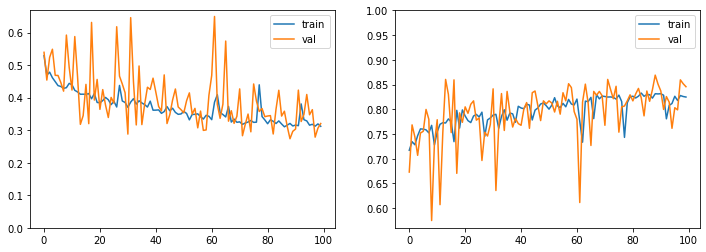

In [8]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6701 - accuracy: 0.5889 - precision: 0.7551 - recall: 0.5836 - f1: 0.6404 - specificity: 0.5956 - negative_predictive_value: 0.4082 - matthews_correlation_coefficient: 0.1763 - val_loss: 0.6917 - val_accuracy: 0.5594 - val_precision: 0.7787 - val_recall: 0.4499 - val_f1: 0.5650 - val_specificity: 0.7695 - val_negative_predictive_value: 0.4104 - val_matthews_correlation_coefficient: 0.2025

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.20251, saving model to ../models/autoencoders_requirements/looking_away_2020_03_29-00_50_08.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6656 - accuracy: 0.6117 - precision: 0.7730 - recall: 0.6226 - f1: 0.6795 - specificity: 0.6006 - negative_predictive_value: 0.4282 - matthews_correlation_coefficient: 0.2112 - val_loss: 0.6728 - val_accuracy: 0.5880 - val_precision

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6211 - accuracy: 0.6577 - precision: 0.8188 - recall: 0.6479 - f1: 0.7125 - specificity: 0.6815 - negative_predictive_value: 0.4766 - matthews_correlation_coefficient: 0.3123 - val_loss: 0.5906 - val_accuracy: 0.6860 - val_precision: 0.8124 - val_recall: 0.6571 - val_f1: 0.7212 - val_specificity: 0.7211 - val_negative_predictive_value: 0.5156 - val_matthews_correlation_coefficient: 0.3512

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.35863
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6124 - accuracy: 0.6633 - precision: 0.8183 - recall: 0.6637 - f1: 0.7246 - specificity: 0.6690 - negative_predictive_value: 0.4779 - matthews_correlation_coefficient: 0.3129 - val_loss: 0.5731 - val_accuracy: 0.7112 - val_precision: 0.7883 - val_recall: 0.7359 - val_f1: 0.7566 - val_specificity: 0.6237 - val_negative_predictive_value: 0.5485 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.38915
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5866 - accuracy: 0.6907 - precision: 0.8360 - recall: 0.6907 - f1: 0.7474 - specificity: 0.6965 - negative_predictive_value: 0.5181 - matthews_correlation_coefficient: 0.3692 - val_loss: 0.6696 - val_accuracy: 0.6505 - val_precision: 0.8230 - val_recall: 0.5796 - val_f1: 0.6750 - val_specificity: 0.7772 - val_negative_predictive_value: 0.4803 - val_matthews_correlation_coefficient: 0.3277

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.38915
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5839 - accuracy: 0.6850 - precision: 0.8333 - recall: 0.6831 - f1: 0.7427 - specificity: 0.6924 - negative_predictive_value: 0.4992 - matthews_correlation_coefficient: 0.3537 - val_loss: 0.5947 - val_accuracy: 0.6834 - val_precision: 0.8166 - val_recall: 0.6454 - val_f1: 0.7167 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5687 - accuracy: 0.7033 - precision: 0.8314 - recall: 0.7196 - f1: 0.7646 - specificity: 0.6779 - negative_predictive_value: 0.5302 - matthews_correlation_coefficient: 0.3779 - val_loss: 0.6856 - val_accuracy: 0.5958 - val_precision: 0.8711 - val_recall: 0.4529 - val_f1: 0.5903 - val_specificity: 0.8945 - val_negative_predictive_value: 0.4469 - val_matthews_correlation_coefficient: 0.3305

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.40214
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5658 - accuracy: 0.7002 - precision: 0.8385 - recall: 0.6900 - f1: 0.7481 - specificity: 0.7098 - negative_predictive_value: 0.5217 - matthews_correlation_coefficient: 0.3779 - val_loss: 0.6387 - val_accuracy: 0.6418 - val_precision: 0.8401 - val_recall: 0.5524 - val_f1: 0.6615 - val_specificity: 0.8149 - val_negative_predictive_value: 0.4740 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient improved from 0.40375 to 0.40408, saving model to ../models/autoencoders_requirements/looking_away_2020_03_29-00_50_08.h5
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5538 - accuracy: 0.7165 - precision: 0.8387 - recall: 0.7195 - f1: 0.7658 - specificity: 0.7075 - negative_predictive_value: 0.5429 - matthews_correlation_coefficient: 0.4019 - val_loss: 0.5841 - val_accuracy: 0.6756 - val_precision: 0.8569 - val_recall: 0.5948 - val_f1: 0.6964 - val_specificity: 0.8265 - val_negative_predictive_value: 0.5032 - val_matthews_correlation_coefficient: 0.3878

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.40408
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5536 - accuracy: 0.7095 - precision: 0.8430 - recall: 0.7140 - f1: 0.7647 - specificity: 0.7054 - negative_predictive_value: 0.5291 - matthews_correlation_coefficient: 0.3955 - val_loss: 0.7080 -


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.40408
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5484 - accuracy: 0.7126 - precision: 0.8572 - recall: 0.7048 - f1: 0.7646 - specificity: 0.7267 - negative_predictive_value: 0.5361 - matthews_correlation_coefficient: 0.4124 - val_loss: 0.5759 - val_accuracy: 0.6912 - val_precision: 0.8340 - val_recall: 0.6374 - val_f1: 0.7188 - val_specificity: 0.7757 - val_negative_predictive_value: 0.5172 - val_matthews_correlation_coefficient: 0.3794

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.40408
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5452 - accuracy: 0.7206 - precision: 0.8509 - recall: 0.7234 - f1: 0.7748 - specificity: 0.7133 - negative_predictive_value: 0.5427 - matthews_correlation_coefficient: 0.4151 - val_loss: 0.7101 - val_accuracy: 0.5906 - val_precision: 0.8600 - val_recall: 0.4541 - val_f1: 0.5882 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.41289
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5377 - accuracy: 0.7269 - precision: 0.8542 - recall: 0.7294 - f1: 0.7785 - specificity: 0.7182 - negative_predictive_value: 0.5568 - matthews_correlation_coefficient: 0.4287 - val_loss: 0.6217 - val_accuracy: 0.6687 - val_precision: 0.8325 - val_recall: 0.5989 - val_f1: 0.6931 - val_specificity: 0.7865 - val_negative_predictive_value: 0.4944 - val_matthews_correlation_coefficient: 0.3536

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.41289
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5366 - accuracy: 0.7282 - precision: 0.8571 - recall: 0.7280 - f1: 0.7798 - specificity: 0.7249 - negative_predictive_value: 0.5609 - matthews_correlation_coefficient: 0.4354 - val_loss: 0.6258 - val_accuracy: 0.6340 - val_precision: 0.8661 - val_recall: 0.5189 - val_f1: 0.6434 - val_spe

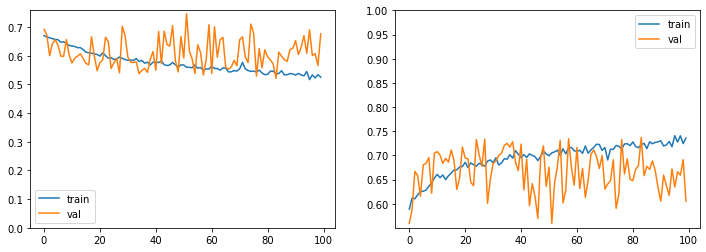

In [9]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

In [10]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

the requirement ink_marked_creased has only one label.


#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6518 - accuracy: 0.6115 - precision: 0.6721 - recall: 0.5809 - f1: 0.5870 - specificity: 0.6502 - negative_predictive_value: 0.5989 - matthews_correlation_coefficient: 0.2470 - val_loss: 0.6145 - val_accuracy: 0.6453 - val_precision: 0.6366 - val_recall: 0.7053 - val_f1: 0.6623 - val_specificity: 0.5361 - val_negative_predictive_value: 0.6150 - val_matthews_correlation_coefficient: 0.2730

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.27304, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_29-01_04_56.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6082 - accuracy: 0.6610 - precision: 0.6764 - recall: 0.6892 - f1: 0.6687 - specificity: 0.6124 - negative_predictive_value: 0.6533 - matthews_correlation_coefficient: 0.3142 - val_loss: 0.6549 - val_accuracy: 0.6227 - val_pr


Epoch 00014: val_matthews_correlation_coefficient improved from 0.44259 to 0.44273, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_29-01_04_56.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5014 - accuracy: 0.7330 - precision: 0.7416 - recall: 0.7831 - f1: 0.7529 - specificity: 0.6822 - negative_predictive_value: 0.7378 - matthews_correlation_coefficient: 0.4718 - val_loss: 0.5260 - val_accuracy: 0.7199 - val_precision: 0.7305 - val_recall: 0.7000 - val_f1: 0.7088 - val_specificity: 0.6944 - val_negative_predictive_value: 0.6672 - val_matthews_correlation_coefficient: 0.4227

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.44273
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5004 - accuracy: 0.7403 - precision: 0.7461 - recall: 0.7971 - f1: 0.7627 - specificity: 0.6821 - negative_predictive_value: 0.7481 - matthews_correlation_coefficient: 0.4861 - val_loss: 0


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.50668
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4709 - accuracy: 0.7623 - precision: 0.7531 - recall: 0.8141 - f1: 0.7774 - specificity: 0.6910 - negative_predictive_value: 0.7636 - matthews_correlation_coefficient: 0.5173 - val_loss: 0.4790 - val_accuracy: 0.7346 - val_precision: 0.6728 - val_recall: 0.8779 - val_f1: 0.7579 - val_specificity: 0.5200 - val_negative_predictive_value: 0.8063 - val_matthews_correlation_coefficient: 0.4625

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.50668
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4739 - accuracy: 0.7497 - precision: 0.7466 - recall: 0.8012 - f1: 0.7645 - specificity: 0.6864 - negative_predictive_value: 0.7688 - matthews_correlation_coefficient: 0.5021 - val_loss: 0.4697 - val_accuracy: 0.7546 - val_precision: 0.7717 - val_recall: 0.7219 - val_f1: 0.7402 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4529 - accuracy: 0.7675 - precision: 0.7632 - recall: 0.8279 - f1: 0.7880 - specificity: 0.7030 - negative_predictive_value: 0.7841 - matthews_correlation_coefficient: 0.5386 - val_loss: 0.4767 - val_accuracy: 0.7598 - val_precision: 0.7995 - val_recall: 0.6990 - val_f1: 0.7395 - val_specificity: 0.7904 - val_negative_predictive_value: 0.6872 - val_matthews_correlation_coefficient: 0.5146

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.51791
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4512 - accuracy: 0.7703 - precision: 0.7743 - recall: 0.8212 - f1: 0.7900 - specificity: 0.7145 - negative_predictive_value: 0.7786 - matthews_correlation_coefficient: 0.5436 - val_loss: 0.4855 - val_accuracy: 0.7459 - val_precision: 0.7272 - val_recall: 0.7746 - val_f1: 0.7450 - val_specificity: 0.6638 - val_negative_predictive_value: 0.7208 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.53464
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4394 - accuracy: 0.7764 - precision: 0.7802 - recall: 0.8193 - f1: 0.7914 - specificity: 0.7305 - negative_predictive_value: 0.7859 - matthews_correlation_coefficient: 0.5575 - val_loss: 0.4753 - val_accuracy: 0.7624 - val_precision: 0.7624 - val_recall: 0.7535 - val_f1: 0.7530 - val_specificity: 0.7200 - val_negative_predictive_value: 0.7143 - val_matthews_correlation_coefficient: 0.5020

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.53464
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4434 - accuracy: 0.7725 - precision: 0.7668 - recall: 0.8249 - f1: 0.7888 - specificity: 0.7104 - negative_predictive_value: 0.7791 - matthews_correlation_coefficient: 0.5419 - val_loss: 0.4970 - val_accuracy: 0.7398 - val_precision: 0.7502 - val_recall: 0.7173 - val_f1: 0.7268 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.55151
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4388 - accuracy: 0.7772 - precision: 0.7736 - recall: 0.8225 - f1: 0.7909 - specificity: 0.7200 - negative_predictive_value: 0.7793 - matthews_correlation_coefficient: 0.5542 - val_loss: 0.4496 - val_accuracy: 0.7736 - val_precision: 0.7559 - val_recall: 0.7947 - val_f1: 0.7705 - val_specificity: 0.6987 - val_negative_predictive_value: 0.7470 - val_matthews_correlation_coefficient: 0.5249

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.55151
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4340 - accuracy: 0.7811 - precision: 0.7842 - recall: 0.8254 - f1: 0.7949 - specificity: 0.7373 - negative_predictive_value: 0.7975 - matthews_correlation_coefficient: 0.5716 - val_loss: 0.4431 - val_accuracy: 0.7667 - val_precision: 0.7425 - val_recall: 0.8093 - val_f1: 0.7705 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.55151
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4245 - accuracy: 0.7831 - precision: 0.7890 - recall: 0.8062 - f1: 0.7899 - specificity: 0.7545 - negative_predictive_value: 0.7821 - matthews_correlation_coefficient: 0.5650 - val_loss: 0.4653 - val_accuracy: 0.7554 - val_precision: 0.7924 - val_recall: 0.7006 - val_f1: 0.7358 - val_specificity: 0.7849 - val_negative_predictive_value: 0.6875 - val_matthews_correlation_coefficient: 0.5094

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.55151
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4210 - accuracy: 0.7863 - precision: 0.7950 - recall: 0.8246 - f1: 0.8014 - specificity: 0.7506 - negative_predictive_value: 0.7893 - matthews_correlation_coefficient: 0.5792 - val_loss: 0.4894 - val_accuracy: 0.7459 - val_precision: 0.7837 - val_recall: 0.6800 - val_f1: 0.7239 - val_spe

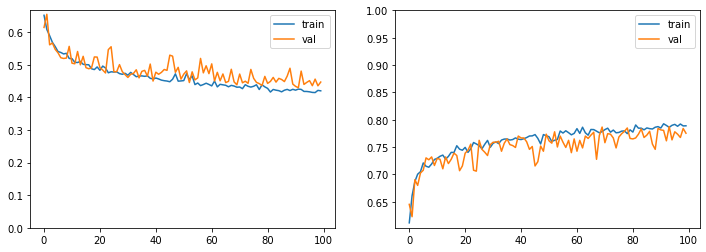

In [11]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6252 - accuracy: 0.6475 - precision: 0.9478 - recall: 0.6515 - f1: 0.7489 - specificity: 0.6486 - negative_predictive_value: 0.2109 - matthews_correlation_coefficient: 0.2155 - val_loss: 0.7365 - val_accuracy: 0.5265 - val_precision: 0.9936 - val_recall: 0.4926 - val_f1: 0.6501 - val_specificity: 0.8662 - val_negative_predictive_value: 0.1712 - val_matthews_correlation_coefficient: 0.2549

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25485, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_29-01_19_38.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5439 - accuracy: 0.7226 - precision: 0.9663 - recall: 0.7208 - f1: 0.8113 - specificity: 0.7326 - negative_predictive_value: 0.2586 - matthews_correlation_coefficient: 0.3119 - val_loss: 0.4092 - val_accuracy: 0.8448 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4147 - accuracy: 0.8056 - precision: 0.9753 - recall: 0.8077 - f1: 0.8794 - specificity: 0.7927 - negative_predictive_value: 0.3314 - matthews_correlation_coefficient: 0.4169 - val_loss: 0.2876 - val_accuracy: 0.8734 - val_precision: 0.9643 - val_recall: 0.8952 - val_f1: 0.9275 - val_specificity: 0.6333 - val_negative_predictive_value: 0.3846 - val_matthews_correlation_coefficient: 0.4257

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.43062
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4133 - accuracy: 0.8221 - precision: 0.9751 - recall: 0.8262 - f1: 0.8912 - specificity: 0.7904 - negative_predictive_value: 0.3472 - matthews_correlation_coefficient: 0.4346 - val_loss: 0.5482 - val_accuracy: 0.7277 - val_precision: 0.9879 - val_recall: 0.7152 - val_f1: 0.8263 - val_specificity: 0.8194 - val_negative_predictive_value: 0.2498 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3823 - accuracy: 0.8321 - precision: 0.9757 - recall: 0.8342 - f1: 0.8958 - specificity: 0.7999 - negative_predictive_value: 0.3703 - matthews_correlation_coefficient: 0.4563 - val_loss: 0.7522 - val_accuracy: 0.6635 - val_precision: 0.9945 - val_recall: 0.6400 - val_f1: 0.7751 - val_specificity: 0.8617 - val_negative_predictive_value: 0.2170 - val_matthews_correlation_coefficient: 0.3305

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.43062
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4240 - accuracy: 0.8009 - precision: 0.9772 - recall: 0.7969 - f1: 0.8685 - specificity: 0.7896 - negative_predictive_value: 0.3401 - matthews_correlation_coefficient: 0.4261 - val_loss: 0.5182 - val_accuracy: 0.7441 - val_precision: 0.9861 - val_recall: 0.7339 - val_f1: 0.8385 - val_specificity: 0.8126 - val_negative_predictive_value: 0.2615 - val_matthews_correlation_coefficie


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.43563
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3479 - accuracy: 0.8449 - precision: 0.9800 - recall: 0.8461 - f1: 0.9061 - specificity: 0.7910 - negative_predictive_value: 0.3826 - matthews_correlation_coefficient: 0.4720 - val_loss: 0.5001 - val_accuracy: 0.7502 - val_precision: 0.9822 - val_recall: 0.7422 - val_f1: 0.8423 - val_specificity: 0.7878 - val_negative_predictive_value: 0.2603 - val_matthews_correlation_coefficient: 0.3592

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.43563
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3619 - accuracy: 0.8390 - precision: 0.9796 - recall: 0.8403 - f1: 0.9023 - specificity: 0.8050 - negative_predictive_value: 0.3790 - matthews_correlation_coefficient: 0.4726 - val_loss: 0.5791 - val_accuracy: 0.7346 - val_precision: 0.9911 - val_recall: 0.7196 - val_f1: 0.8309 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.46085
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3300 - accuracy: 0.8475 - precision: 0.9806 - recall: 0.8455 - f1: 0.9057 - specificity: 0.7873 - negative_predictive_value: 0.3818 - matthews_correlation_coefficient: 0.4711 - val_loss: 0.4202 - val_accuracy: 0.8049 - val_precision: 0.9795 - val_recall: 0.8055 - val_f1: 0.8817 - val_specificity: 0.7590 - val_negative_predictive_value: 0.3089 - val_matthews_correlation_coefficient: 0.4003

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.46085
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3419 - accuracy: 0.8440 - precision: 0.9821 - recall: 0.8439 - f1: 0.9052 - specificity: 0.8388 - negative_predictive_value: 0.4096 - matthews_correlation_coefficient: 0.5038 - val_loss: 0.5274 - val_accuracy: 0.7554 - val_precision: 0.9843 - val_recall: 0.7475 - val_f1: 0.8468 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.46085
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3308 - accuracy: 0.8425 - precision: 0.9845 - recall: 0.8405 - f1: 0.9041 - specificity: 0.8412 - negative_predictive_value: 0.3855 - matthews_correlation_coefficient: 0.4910 - val_loss: 0.3720 - val_accuracy: 0.8352 - val_precision: 0.9763 - val_recall: 0.8425 - val_f1: 0.9032 - val_specificity: 0.7320 - val_negative_predictive_value: 0.3368 - val_matthews_correlation_coefficient: 0.4233

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.46085
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3198 - accuracy: 0.8551 - precision: 0.9818 - recall: 0.8559 - f1: 0.9128 - specificity: 0.8379 - negative_predictive_value: 0.4054 - matthews_correlation_coefficient: 0.5095 - val_loss: 0.4110 - val_accuracy: 0.8239 - val_precision: 0.9780 - val_recall: 0.8283 - val_f1: 0.8951 - val_spe

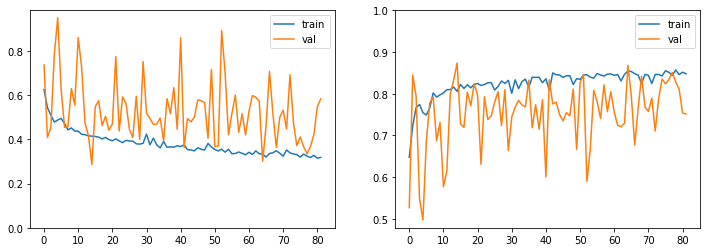

In [12]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5635 - accuracy: 0.7714 - precision: 0.9930 - recall: 0.7729 - f1: 0.8591 - specificity: 0.2126 - negative_predictive_value: 0.0339 - matthews_correlation_coefficient: 0.0622 - val_loss: 0.5684 - val_accuracy: 0.6739 - val_precision: 0.9986 - val_recall: 0.6795 - val_f1: 0.8057 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0382 - val_matthews_correlation_coefficient: 0.0844

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.08440, saving model to ../models/autoencoders_requirements/washed_out_2020_03_29-01_31_43.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4325 - accuracy: 0.7059 - precision: 0.9989 - recall: 0.7044 - f1: 0.8169 - specificity: 0.3080 - negative_predictive_value: 0.0387 - matthews_correlation_coefficient: 0.0865 - val_loss: 0.1260 - val_accuracy: 0.9748 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3012 - accuracy: 0.8100 - precision: 0.9984 - recall: 0.8103 - f1: 0.8904 - specificity: 0.3046 - negative_predictive_value: 0.0625 - matthews_correlation_coefficient: 0.1161 - val_loss: 0.2166 - val_accuracy: 0.8907 - val_precision: 0.9953 - val_recall: 0.8968 - val_f1: 0.9424 - val_specificity: 0.2162 - val_negative_predictive_value: 0.0860 - val_matthews_correlation_coefficient: 0.1213

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.15088
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2783 - accuracy: 0.8349 - precision: 0.9985 - recall: 0.8352 - f1: 0.9055 - specificity: 0.3276 - negative_predictive_value: 0.0874 - matthews_correlation_coefficient: 0.1437 - val_loss: 0.3154 - val_accuracy: 0.8092 - val_precision: 0.9959 - val_recall: 0.8155 - val_f1: 0.8950 - val_specificity: 0.2297 - val_negative_predictive_value: 0.0540 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2245 - accuracy: 0.8783 - precision: 0.9985 - recall: 0.8787 - f1: 0.9328 - specificity: 0.3310 - negative_predictive_value: 0.1127 - matthews_correlation_coefficient: 0.1694 - val_loss: 0.2003 - val_accuracy: 0.9003 - val_precision: 0.9954 - val_recall: 0.9062 - val_f1: 0.9477 - val_specificity: 0.2162 - val_negative_predictive_value: 0.1108 - val_matthews_correlation_coefficient: 0.1340

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.15088
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2468 - accuracy: 0.8657 - precision: 0.9984 - recall: 0.8666 - f1: 0.9229 - specificity: 0.2862 - negative_predictive_value: 0.1137 - matthews_correlation_coefficient: 0.1601 - val_loss: 0.1610 - val_accuracy: 0.9332 - val_precision: 0.9955 - val_recall: 0.9386 - val_f1: 0.9656 - val_specificity: 0.2162 - val_negative_predictive_value: 0.1441 - val_matthews_correlation_coefficie


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.16207
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2478 - accuracy: 0.8623 - precision: 0.9984 - recall: 0.8631 - f1: 0.9234 - specificity: 0.3517 - negative_predictive_value: 0.0970 - matthews_correlation_coefficient: 0.1664 - val_loss: 0.2247 - val_accuracy: 0.8985 - val_precision: 0.9954 - val_recall: 0.9044 - val_f1: 0.9467 - val_specificity: 0.2162 - val_negative_predictive_value: 0.1086 - val_matthews_correlation_coefficient: 0.1308

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.16207
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2163 - accuracy: 0.8766 - precision: 0.9985 - recall: 0.8741 - f1: 0.9308 - specificity: 0.3103 - negative_predictive_value: 0.1047 - matthews_correlation_coefficient: 0.1644 - val_loss: 0.2776 - val_accuracy: 0.8647 - val_precision: 0.9971 - val_recall: 0.8693 - val_f1: 0.9277 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.18336
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2183 - accuracy: 0.8885 - precision: 0.9990 - recall: 0.8856 - f1: 0.9367 - specificity: 0.3241 - negative_predictive_value: 0.1235 - matthews_correlation_coefficient: 0.1811 - val_loss: 0.2963 - val_accuracy: 0.8552 - val_precision: 0.9971 - val_recall: 0.8599 - val_f1: 0.9223 - val_specificity: 0.2568 - val_negative_predictive_value: 0.0749 - val_matthews_correlation_coefficient: 0.1216

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.18336
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2004 - accuracy: 0.8896 - precision: 0.9991 - recall: 0.8898 - f1: 0.9398 - specificity: 0.3724 - negative_predictive_value: 0.1189 - matthews_correlation_coefficient: 0.1912 - val_loss: 0.2661 - val_accuracy: 0.8794 - val_precision: 0.9973 - val_recall: 0.8840 - val_f1: 0.9363 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.18336
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1968 - accuracy: 0.8963 - precision: 0.9988 - recall: 0.8967 - f1: 0.9434 - specificity: 0.3356 - negative_predictive_value: 0.1256 - matthews_correlation_coefficient: 0.1853 - val_loss: 0.1759 - val_accuracy: 0.9167 - val_precision: 0.9965 - val_recall: 0.9216 - val_f1: 0.9567 - val_specificity: 0.2432 - val_negative_predictive_value: 0.1356 - val_matthews_correlation_coefficient: 0.1632

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.18336
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1760 - accuracy: 0.9091 - precision: 0.9991 - recall: 0.9062 - f1: 0.9483 - specificity: 0.3345 - negative_predictive_value: 0.1529 - matthews_correlation_coefficient: 0.2056 - val_loss: 0.4239 - val_accuracy: 0.7997 - val_precision: 0.9989 - val_recall: 0.8035 - val_f1: 0.8886 - val_spe

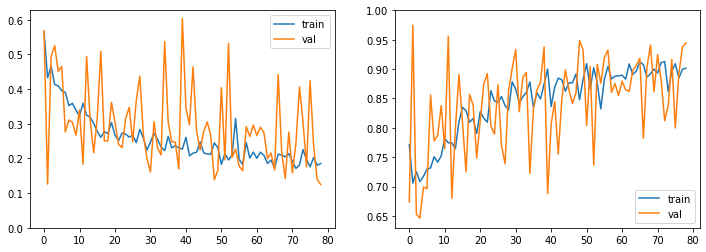

In [13]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6664 - accuracy: 0.5898 - precision: 0.9482 - recall: 0.5857 - f1: 0.7050 - specificity: 0.5833 - negative_predictive_value: 0.1198 - matthews_correlation_coefficient: 0.1304 - val_loss: 0.7985 - val_accuracy: 0.4753 - val_precision: 0.9714 - val_recall: 0.4663 - val_f1: 0.6219 - val_specificity: 0.6748 - val_negative_predictive_value: 0.0947 - val_matthews_correlation_coefficient: 0.1130

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.11298, saving model to ../models/autoencoders_requirements/pixelation_2020_03_29-01_43_26.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6371 - accuracy: 0.5998 - precision: 0.9644 - recall: 0.5972 - f1: 0.7257 - specificity: 0.5756 - negative_predictive_value: 0.1096 - matthews_correlation_coefficient: 0.1255 - val_loss: 0.6230 - val_accuracy: 0.5620 - val_precision: 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.23723
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5424 - accuracy: 0.6746 - precision: 0.9745 - recall: 0.6677 - f1: 0.7874 - specificity: 0.6964 - negative_predictive_value: 0.1479 - matthews_correlation_coefficient: 0.2154 - val_loss: 0.4068 - val_accuracy: 0.8005 - val_precision: 0.9706 - val_recall: 0.8162 - val_f1: 0.8852 - val_specificity: 0.5491 - val_negative_predictive_value: 0.1862 - val_matthews_correlation_coefficient: 0.2399

Epoch 00015: val_matthews_correlation_coefficient improved from 0.23723 to 0.23987, saving model to ../models/autoencoders_requirements/pixelation_2020_03_29-01_43_26.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5136 - accuracy: 0.6907 - precision: 0.9768 - recall: 0.6840 - f1: 0.7998 - specificity: 0.6838 - negative_predictive_value: 0.1548 - matthews_correlation_coefficient: 0.2240 - val_loss: 0.3232 - v


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.23987
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4834 - accuracy: 0.7167 - precision: 0.9777 - recall: 0.7149 - f1: 0.8226 - specificity: 0.7105 - negative_predictive_value: 0.1717 - matthews_correlation_coefficient: 0.2508 - val_loss: 0.4358 - val_accuracy: 0.7138 - val_precision: 0.9716 - val_recall: 0.7219 - val_f1: 0.8262 - val_specificity: 0.5982 - val_negative_predictive_value: 0.1407 - val_matthews_correlation_coefficient: 0.1914

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.23987
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4912 - accuracy: 0.6857 - precision: 0.9798 - recall: 0.6788 - f1: 0.7976 - specificity: 0.7408 - negative_predictive_value: 0.1568 - matthews_correlation_coefficient: 0.2399 - val_loss: 0.3195 - val_accuracy: 0.8534 - val_precision: 0.9622 - val_recall: 0.8815 - val_f1: 0.9190 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.25260
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4545 - accuracy: 0.7371 - precision: 0.9807 - recall: 0.7309 - f1: 0.8346 - specificity: 0.7510 - negative_predictive_value: 0.1805 - matthews_correlation_coefficient: 0.2768 - val_loss: 0.3619 - val_accuracy: 0.7849 - val_precision: 0.9705 - val_recall: 0.8001 - val_f1: 0.8753 - val_specificity: 0.5626 - val_negative_predictive_value: 0.1709 - val_matthews_correlation_coefficient: 0.2255

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.25260
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4644 - accuracy: 0.7210 - precision: 0.9817 - recall: 0.7166 - f1: 0.8246 - specificity: 0.6925 - negative_predictive_value: 0.1802 - matthews_correlation_coefficient: 0.2623 - val_loss: 0.3618 - val_accuracy: 0.8213 - val_precision: 0.9665 - val_recall: 0.8425 - val_f1: 0.8990 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.25260
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4549 - accuracy: 0.7315 - precision: 0.9757 - recall: 0.7289 - f1: 0.8297 - specificity: 0.7231 - negative_predictive_value: 0.1797 - matthews_correlation_coefficient: 0.2653 - val_loss: 0.4980 - val_accuracy: 0.6938 - val_precision: 0.9760 - val_recall: 0.6967 - val_f1: 0.8101 - val_specificity: 0.6410 - val_negative_predictive_value: 0.1370 - val_matthews_correlation_coefficient: 0.1986

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.25260
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6297 - accuracy: 0.6642 - precision: 0.9615 - recall: 0.6588 - f1: 0.7607 - specificity: 0.6536 - negative_predictive_value: 0.1553 - matthews_correlation_coefficient: 0.2143 - val_loss: 0.4332 - val_accuracy: 0.7476 - val_precision: 0.9742 - val_recall: 0.7559 - val_f1: 0.8493 - val_spe

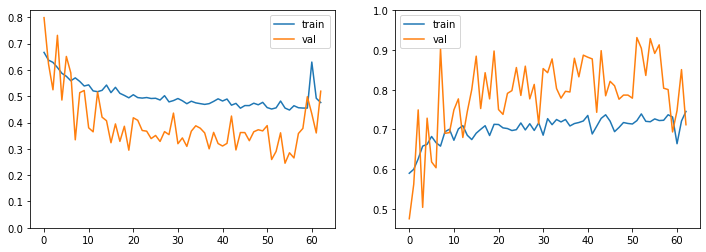

In [14]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5710 - accuracy: 0.6987 - precision: 0.9316 - recall: 0.6848 - f1: 0.7813 - specificity: 0.7597 - negative_predictive_value: 0.3447 - matthews_correlation_coefficient: 0.3486 - val_loss: 0.5051 - val_accuracy: 0.6808 - val_precision: 0.9498 - val_recall: 0.6518 - val_f1: 0.7693 - val_specificity: 0.8382 - val_negative_predictive_value: 0.3458 - val_matthews_correlation_coefficient: 0.3778

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.37780, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_29-01_52_48.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5472 - accuracy: 0.6909 - precision: 0.9522 - recall: 0.6534 - f1: 0.7699 - specificity: 0.8475 - negative_predictive_value: 0.3600 - matthews_correlation_coefficient: 0.3922 - val_loss: 0.6384 - val_accuracy: 0.6678 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4911 - accuracy: 0.7477 - precision: 0.9450 - recall: 0.7331 - f1: 0.8212 - specificity: 0.8005 - negative_predictive_value: 0.4104 - matthews_correlation_coefficient: 0.4315 - val_loss: 0.4550 - val_accuracy: 0.7606 - val_precision: 0.9193 - val_recall: 0.7809 - val_f1: 0.8424 - val_specificity: 0.6901 - val_negative_predictive_value: 0.4079 - val_matthews_correlation_coefficient: 0.3894

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.41522
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4962 - accuracy: 0.7495 - precision: 0.9424 - recall: 0.7430 - f1: 0.8257 - specificity: 0.7947 - negative_predictive_value: 0.4228 - matthews_correlation_coefficient: 0.4376 - val_loss: 0.5986 - val_accuracy: 0.6791 - val_precision: 0.9600 - val_recall: 0.6434 - val_f1: 0.7660 - val_specificity: 0.8722 - val_negative_predictive_value: 0.3508 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.43711
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4601 - accuracy: 0.7811 - precision: 0.9474 - recall: 0.7758 - f1: 0.8490 - specificity: 0.8073 - negative_predictive_value: 0.4573 - matthews_correlation_coefficient: 0.4814 - val_loss: 0.4665 - val_accuracy: 0.7780 - val_precision: 0.9211 - val_recall: 0.8011 - val_f1: 0.8552 - val_specificity: 0.6916 - val_negative_predictive_value: 0.4310 - val_matthews_correlation_coefficient: 0.4134

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.43711
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4749 - accuracy: 0.7738 - precision: 0.9459 - recall: 0.7711 - f1: 0.8432 - specificity: 0.8117 - negative_predictive_value: 0.4614 - matthews_correlation_coefficient: 0.4797 - val_loss: 0.5565 - val_accuracy: 0.6964 - val_precision: 0.9472 - val_recall: 0.6747 - val_f1: 0.7846 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.43711
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4537 - accuracy: 0.7885 - precision: 0.9451 - recall: 0.7882 - f1: 0.8558 - specificity: 0.7938 - negative_predictive_value: 0.4690 - matthews_correlation_coefficient: 0.4874 - val_loss: 0.6023 - val_accuracy: 0.7103 - val_precision: 0.9498 - val_recall: 0.6904 - val_f1: 0.7962 - val_specificity: 0.8180 - val_negative_predictive_value: 0.3660 - val_matthews_correlation_coefficient: 0.3975

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.43711
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4494 - accuracy: 0.7811 - precision: 0.9389 - recall: 0.7716 - f1: 0.8436 - specificity: 0.8010 - negative_predictive_value: 0.4488 - matthews_correlation_coefficient: 0.4665 - val_loss: 0.6662 - val_accuracy: 0.6383 - val_precision: 0.9660 - val_recall: 0.5862 - val_f1: 0.7231 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.45228
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4606 - accuracy: 0.7610 - precision: 0.9467 - recall: 0.7527 - f1: 0.8332 - specificity: 0.8006 - negative_predictive_value: 0.4355 - matthews_correlation_coefficient: 0.4551 - val_loss: 0.5052 - val_accuracy: 0.7433 - val_precision: 0.9344 - val_recall: 0.7433 - val_f1: 0.8252 - val_specificity: 0.7634 - val_negative_predictive_value: 0.3983 - val_matthews_correlation_coefficient: 0.4071

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.45228
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4273 - accuracy: 0.7894 - precision: 0.9486 - recall: 0.7873 - f1: 0.8572 - specificity: 0.8127 - negative_predictive_value: 0.4717 - matthews_correlation_coefficient: 0.4972 - val_loss: 0.5145 - val_accuracy: 0.7415 - val_precision: 0.9336 - val_recall: 0.7423 - val_f1: 0.8247 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.45228
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4173 - accuracy: 0.7974 - precision: 0.9514 - recall: 0.7952 - f1: 0.8633 - specificity: 0.8161 - negative_predictive_value: 0.4783 - matthews_correlation_coefficient: 0.5075 - val_loss: 0.5827 - val_accuracy: 0.6904 - val_precision: 0.9493 - val_recall: 0.6635 - val_f1: 0.7770 - val_specificity: 0.8372 - val_negative_predictive_value: 0.3536 - val_matthews_correlation_coefficient: 0.3865

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.45228
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4241 - accuracy: 0.7963 - precision: 0.9559 - recall: 0.7911 - f1: 0.8611 - specificity: 0.8335 - negative_predictive_value: 0.4904 - matthews_correlation_coefficient: 0.5216 - val_loss: 0.6141 - val_accuracy: 0.6982 - val_precision: 0.9480 - val_recall: 0.6761 - val_f1: 0.7858 - val_spe

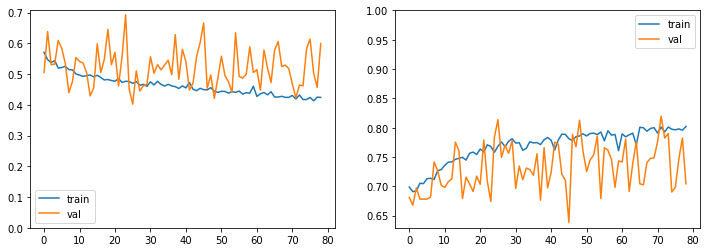

In [15]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6380 - accuracy: 0.5341 - precision: 0.9096 - recall: 0.4645 - f1: 0.6014 - specificity: 0.8013 - negative_predictive_value: 0.2692 - matthews_correlation_coefficient: 0.2202 - val_loss: 0.5872 - val_accuracy: 0.5828 - val_precision: 0.9206 - val_recall: 0.5358 - val_f1: 0.6679 - val_specificity: 0.7806 - val_negative_predictive_value: 0.2989 - val_matthews_correlation_coefficient: 0.2618

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.26179, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_29-02_04_29.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6297 - accuracy: 0.5393 - precision: 0.9198 - recall: 0.4640 - f1: 0.6044 - specificity: 0.8208 - negative_predictive_value: 0.2901 - matthews_correlation_coefficient: 0.2429 - val_loss: 0.6966 - val_accuracy: 0.4692 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5949 - accuracy: 0.6249 - precision: 0.9150 - recall: 0.5880 - f1: 0.7043 - specificity: 0.7783 - negative_predictive_value: 0.3344 - matthews_correlation_coefficient: 0.2986 - val_loss: 0.5238 - val_accuracy: 0.7363 - val_precision: 0.8843 - val_recall: 0.7790 - val_f1: 0.8251 - val_specificity: 0.5824 - val_negative_predictive_value: 0.4041 - val_matthews_correlation_coefficient: 0.3209

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.33134
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5840 - accuracy: 0.6462 - precision: 0.9127 - recall: 0.6134 - f1: 0.7244 - specificity: 0.7710 - negative_predictive_value: 0.3501 - matthews_correlation_coefficient: 0.3159 - val_loss: 0.5718 - val_accuracy: 0.6539 - val_precision: 0.9293 - val_recall: 0.6206 - val_f1: 0.7364 - val_specificity: 0.7927 - val_negative_predictive_value: 0.3517 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5698 - accuracy: 0.6512 - precision: 0.9120 - recall: 0.6231 - f1: 0.7274 - specificity: 0.7543 - negative_predictive_value: 0.3602 - matthews_correlation_coefficient: 0.3192 - val_loss: 0.5814 - val_accuracy: 0.6652 - val_precision: 0.9303 - val_recall: 0.6341 - val_f1: 0.7480 - val_specificity: 0.8000 - val_negative_predictive_value: 0.3614 - val_matthews_correlation_coefficient: 0.3542

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.37133
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5484 - accuracy: 0.6796 - precision: 0.9153 - recall: 0.6619 - f1: 0.7606 - specificity: 0.7433 - negative_predictive_value: 0.3657 - matthews_correlation_coefficient: 0.3342 - val_loss: 0.5898 - val_accuracy: 0.6539 - val_precision: 0.9392 - val_recall: 0.6129 - val_f1: 0.7341 - val_specificity: 0.8261 - val_negative_predictive_value: 0.3572 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5358 - accuracy: 0.6868 - precision: 0.9268 - recall: 0.6587 - f1: 0.7610 - specificity: 0.7835 - negative_predictive_value: 0.3804 - matthews_correlation_coefficient: 0.3651 - val_loss: 0.5228 - val_accuracy: 0.7016 - val_precision: 0.9211 - val_recall: 0.6890 - val_f1: 0.7846 - val_specificity: 0.7547 - val_negative_predictive_value: 0.3863 - val_matthews_correlation_coefficient: 0.3677

Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.38747
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5242 - accuracy: 0.7028 - precision: 0.9288 - recall: 0.6781 - f1: 0.7775 - specificity: 0.7952 - negative_predictive_value: 0.3987 - matthews_correlation_coefficient: 0.3920 - val_loss: 0.5066 - val_accuracy: 0.7268 - val_precision: 0.9182 - val_recall: 0.7290 - val_f1: 0.8094 - val_specificity: 0.7277 - val_negative_predictive_value: 0.4056 - val_matthews_correlation_coefficie


Epoch 00056: val_matthews_correlation_coefficient did not improve from 0.39328
Epoch 57/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5188 - accuracy: 0.7215 - precision: 0.9146 - recall: 0.7080 - f1: 0.7922 - specificity: 0.7680 - negative_predictive_value: 0.4180 - matthews_correlation_coefficient: 0.3961 - val_loss: 0.5293 - val_accuracy: 0.6869 - val_precision: 0.9308 - val_recall: 0.6609 - val_f1: 0.7678 - val_specificity: 0.7897 - val_negative_predictive_value: 0.3773 - val_matthews_correlation_coefficient: 0.3711

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.39328
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5188 - accuracy: 0.7128 - precision: 0.9223 - recall: 0.7014 - f1: 0.7916 - specificity: 0.7656 - negative_predictive_value: 0.4012 - matthews_correlation_coefficient: 0.3855 - val_loss: 0.4537 - val_accuracy: 0.7658 - val_precision: 0.8910 - val_recall: 0.8096 - val_f1: 0.8459 - val_spe


Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.40261
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5282 - accuracy: 0.7145 - precision: 0.9231 - recall: 0.6975 - f1: 0.7869 - specificity: 0.7570 - negative_predictive_value: 0.4082 - matthews_correlation_coefficient: 0.3858 - val_loss: 0.5619 - val_accuracy: 0.6782 - val_precision: 0.9233 - val_recall: 0.6550 - val_f1: 0.7610 - val_specificity: 0.7604 - val_negative_predictive_value: 0.3663 - val_matthews_correlation_coefficient: 0.3456

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.40261
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5111 - accuracy: 0.7187 - precision: 0.9146 - recall: 0.7033 - f1: 0.7872 - specificity: 0.7549 - negative_predictive_value: 0.4132 - matthews_correlation_coefficient: 0.3899 - val_loss: 0.5371 - val_accuracy: 0.6904 - val_precision: 0.9315 - val_recall: 0.6652 - val_f1: 0.7711 - val_spe


Epoch 00086: val_matthews_correlation_coefficient improved from 0.41683 to 0.42449, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_29-02_04_29.h5
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4873 - accuracy: 0.7399 - precision: 0.9277 - recall: 0.7344 - f1: 0.8147 - specificity: 0.7761 - negative_predictive_value: 0.4369 - matthews_correlation_coefficient: 0.4273 - val_loss: 0.6835 - val_accuracy: 0.6132 - val_precision: 0.9192 - val_recall: 0.5679 - val_f1: 0.6939 - val_specificity: 0.7857 - val_negative_predictive_value: 0.3215 - val_matthews_correlation_coefficient: 0.2899

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.42449
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5115 - accuracy: 0.7308 - precision: 0.9198 - recall: 0.7293 - f1: 0.8048 - specificity: 0.7428 - negative_predictive_value: 0.4359 - matthews_correlation_coefficient: 0.4054 - val_loss: 0.6636 - 

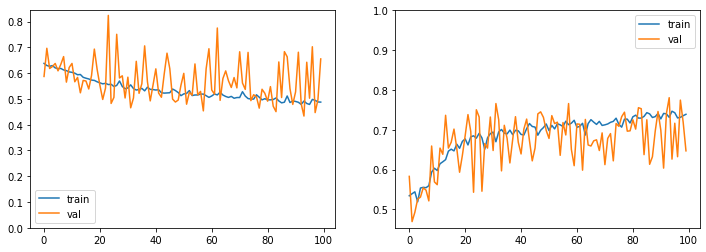

In [16]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5044 - accuracy: 0.7406 - precision: 0.7851 - recall: 0.7226 - f1: 0.7318 - specificity: 0.7638 - negative_predictive_value: 0.7156 - matthews_correlation_coefficient: 0.5039 - val_loss: 0.3906 - val_accuracy: 0.8153 - val_precision: 0.8076 - val_recall: 0.8132 - val_f1: 0.8060 - val_specificity: 0.7890 - val_negative_predictive_value: 0.8005 - val_matthews_correlation_coefficient: 0.6049

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.60487, saving model to ../models/autoencoders_requirements/varied_background_2020_03_29-02_19_19.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4315 - accuracy: 0.7783 - precision: 0.8281 - recall: 0.7726 - f1: 0.7847 - specificity: 0.7903 - negative_predictive_value: 0.7512 - matthews_correlation_coefficient: 0.5703 - val_loss: 0.3823 - val_accuracy: 0.8118 - val_prec


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.68170
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3530 - accuracy: 0.8239 - precision: 0.8639 - recall: 0.8259 - f1: 0.8360 - specificity: 0.8345 - negative_predictive_value: 0.7943 - matthews_correlation_coefficient: 0.6588 - val_loss: 0.3512 - val_accuracy: 0.8291 - val_precision: 0.9229 - val_recall: 0.7106 - val_f1: 0.7979 - val_specificity: 0.9568 - val_negative_predictive_value: 0.7428 - val_matthews_correlation_coefficient: 0.6658

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.68170
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3354 - accuracy: 0.8373 - precision: 0.8728 - recall: 0.8367 - f1: 0.8483 - specificity: 0.8447 - negative_predictive_value: 0.8079 - matthews_correlation_coefficient: 0.6804 - val_loss: 0.3642 - val_accuracy: 0.8040 - val_precision: 0.7309 - val_recall: 0.9427 - val_f1: 0.8196 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3219 - accuracy: 0.8408 - precision: 0.8712 - recall: 0.8437 - f1: 0.8521 - specificity: 0.8360 - negative_predictive_value: 0.8040 - matthews_correlation_coefficient: 0.6771 - val_loss: 0.3065 - val_accuracy: 0.8465 - val_precision: 0.8979 - val_recall: 0.7664 - val_f1: 0.8225 - val_specificity: 0.9225 - val_negative_predictive_value: 0.7794 - val_matthews_correlation_coefficient: 0.6827

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.69941
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3167 - accuracy: 0.8466 - precision: 0.8700 - recall: 0.8436 - f1: 0.8517 - specificity: 0.8473 - negative_predictive_value: 0.8179 - matthews_correlation_coefficient: 0.6908 - val_loss: 0.2855 - val_accuracy: 0.8569 - val_precision: 0.8792 - val_recall: 0.8062 - val_f1: 0.8363 - val_specificity: 0.8945 - val_negative_predictive_value: 0.8141 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.72339
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3293 - accuracy: 0.8419 - precision: 0.8784 - recall: 0.8436 - f1: 0.8534 - specificity: 0.8479 - negative_predictive_value: 0.8148 - matthews_correlation_coefficient: 0.6918 - val_loss: 0.2781 - val_accuracy: 0.8682 - val_precision: 0.8442 - val_recall: 0.8768 - val_f1: 0.8564 - val_specificity: 0.8352 - val_negative_predictive_value: 0.8685 - val_matthews_correlation_coefficient: 0.7120

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.72339
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2979 - accuracy: 0.8534 - precision: 0.8822 - recall: 0.8483 - f1: 0.8598 - specificity: 0.8558 - negative_predictive_value: 0.8172 - matthews_correlation_coefficient: 0.7032 - val_loss: 0.2783 - val_accuracy: 0.8638 - val_precision: 0.8706 - val_recall: 0.8357 - val_f1: 0.8480 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.73282
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2779 - accuracy: 0.8646 - precision: 0.8906 - recall: 0.8702 - f1: 0.8757 - specificity: 0.8662 - negative_predictive_value: 0.8414 - matthews_correlation_coefficient: 0.7339 - val_loss: 0.2598 - val_accuracy: 0.8716 - val_precision: 0.8978 - val_recall: 0.8142 - val_f1: 0.8499 - val_specificity: 0.9163 - val_negative_predictive_value: 0.8230 - val_matthews_correlation_coefficient: 0.7254

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.73282
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2919 - accuracy: 0.8610 - precision: 0.8821 - recall: 0.8572 - f1: 0.8650 - specificity: 0.8588 - negative_predictive_value: 0.8249 - matthews_correlation_coefficient: 0.7110 - val_loss: 0.3135 - val_accuracy: 0.8482 - val_precision: 0.9134 - val_recall: 0.7478 - val_f1: 0.8182 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.73282
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2734 - accuracy: 0.8649 - precision: 0.8963 - recall: 0.8609 - f1: 0.8740 - specificity: 0.8733 - negative_predictive_value: 0.8353 - matthews_correlation_coefficient: 0.7325 - val_loss: 0.2469 - val_accuracy: 0.8725 - val_precision: 0.8661 - val_recall: 0.8531 - val_f1: 0.8561 - val_specificity: 0.8730 - val_negative_predictive_value: 0.8518 - val_matthews_correlation_coefficient: 0.7218

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.73282
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2732 - accuracy: 0.8610 - precision: 0.8873 - recall: 0.8520 - f1: 0.8649 - specificity: 0.8651 - negative_predictive_value: 0.8303 - matthews_correlation_coefficient: 0.7188 - val_loss: 0.2639 - val_accuracy: 0.8656 - val_precision: 0.8658 - val_recall: 0.8413 - val_f1: 0.8489 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2754 - accuracy: 0.8638 - precision: 0.8836 - recall: 0.8618 - f1: 0.8678 - specificity: 0.8643 - negative_predictive_value: 0.8407 - matthews_correlation_coefficient: 0.7248 - val_loss: 0.3205 - val_accuracy: 0.8508 - val_precision: 0.8193 - val_recall: 0.8752 - val_f1: 0.8428 - val_specificity: 0.7964 - val_negative_predictive_value: 0.8639 - val_matthews_correlation_coefficient: 0.6771

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.74410
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2638 - accuracy: 0.8759 - precision: 0.9046 - recall: 0.8715 - f1: 0.8834 - specificity: 0.8856 - negative_predictive_value: 0.8460 - matthews_correlation_coefficient: 0.7534 - val_loss: 0.2950 - val_accuracy: 0.8500 - val_precision: 0.8493 - val_recall: 0.8260 - val_f1: 0.8337 - val_specificity: 0.8530 - val_negative_predictive_value: 0.8252 - val_matthews_correlation_coefficie

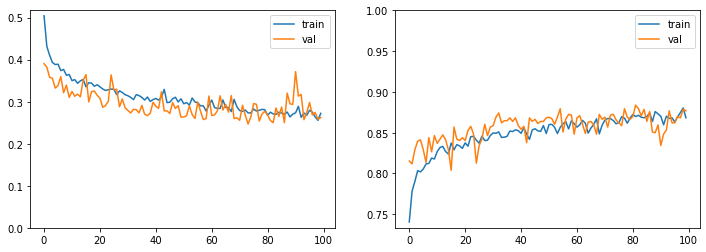

In [17]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5996 - accuracy: 0.6939 - precision: 0.8873 - recall: 0.6798 - f1: 0.7631 - specificity: 0.7417 - negative_predictive_value: 0.4399 - matthews_correlation_coefficient: 0.3703 - val_loss: 0.5722 - val_accuracy: 0.6982 - val_precision: 0.8806 - val_recall: 0.6497 - val_f1: 0.7439 - val_specificity: 0.7883 - val_negative_predictive_value: 0.4397 - val_matthews_correlation_coefficient: 0.3993

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.39925, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_29-02_34_07.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5839 - accuracy: 0.7022 - precision: 0.8996 - recall: 0.6763 - f1: 0.7678 - specificity: 0.7787 - negative_predictive_value: 0.4494 - matthews_correlation_coefficient: 0.3974 - val_loss: 0.5442 - val_accuracy: 0.7008 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5715 - accuracy: 0.7102 - precision: 0.9019 - recall: 0.6862 - f1: 0.7761 - specificity: 0.7782 - negative_predictive_value: 0.4559 - matthews_correlation_coefficient: 0.4058 - val_loss: 0.5843 - val_accuracy: 0.6973 - val_precision: 0.8809 - val_recall: 0.6482 - val_f1: 0.7425 - val_specificity: 0.7914 - val_negative_predictive_value: 0.4399 - val_matthews_correlation_coefficient: 0.4002

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.40877
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5669 - accuracy: 0.7087 - precision: 0.9002 - recall: 0.6869 - f1: 0.7754 - specificity: 0.7761 - negative_predictive_value: 0.4545 - matthews_correlation_coefficient: 0.4034 - val_loss: 0.5476 - val_accuracy: 0.7016 - val_precision: 0.8671 - val_recall: 0.6672 - val_f1: 0.7503 - val_specificity: 0.7509 - val_negative_predictive_value: 0.4404 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.40910
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5631 - accuracy: 0.7124 - precision: 0.9015 - recall: 0.6881 - f1: 0.7769 - specificity: 0.7788 - negative_predictive_value: 0.4580 - matthews_correlation_coefficient: 0.4093 - val_loss: 0.5742 - val_accuracy: 0.7042 - val_precision: 0.8764 - val_recall: 0.6615 - val_f1: 0.7503 - val_specificity: 0.7778 - val_negative_predictive_value: 0.4451 - val_matthews_correlation_coefficient: 0.4005

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.40910
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5608 - accuracy: 0.7104 - precision: 0.9004 - recall: 0.6870 - f1: 0.7744 - specificity: 0.7883 - negative_predictive_value: 0.4601 - matthews_correlation_coefficient: 0.4136 - val_loss: 0.6205 - val_accuracy: 0.6774 - val_precision: 0.8910 - val_recall: 0.6105 - val_f1: 0.7195 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5559 - accuracy: 0.7128 - precision: 0.9067 - recall: 0.6885 - f1: 0.7786 - specificity: 0.7929 - negative_predictive_value: 0.4670 - matthews_correlation_coefficient: 0.4222 - val_loss: 0.5414 - val_accuracy: 0.7147 - val_precision: 0.8662 - val_recall: 0.6861 - val_f1: 0.7626 - val_specificity: 0.7417 - val_negative_predictive_value: 0.4532 - val_matthews_correlation_coefficient: 0.3945

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.41605
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5563 - accuracy: 0.7059 - precision: 0.9056 - recall: 0.6779 - f1: 0.7697 - specificity: 0.7952 - negative_predictive_value: 0.4554 - matthews_correlation_coefficient: 0.4132 - val_loss: 0.5871 - val_accuracy: 0.6756 - val_precision: 0.8798 - val_recall: 0.6161 - val_f1: 0.7209 - val_specificity: 0.7961 - val_negative_predictive_value: 0.4188 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient improved from 0.41744 to 0.41965, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_29-02_34_07.h5
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5496 - accuracy: 0.7184 - precision: 0.9066 - recall: 0.6958 - f1: 0.7845 - specificity: 0.7868 - negative_predictive_value: 0.4668 - matthews_correlation_coefficient: 0.4231 - val_loss: 0.5337 - val_accuracy: 0.7216 - val_precision: 0.8517 - val_recall: 0.7144 - val_f1: 0.7724 - val_specificity: 0.6876 - val_negative_predictive_value: 0.4659 - val_matthews_correlation_coefficient: 0.3818

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.41965
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5483 - accuracy: 0.7187 - precision: 0.9054 - recall: 0.6948 - f1: 0.7831 - specificity: 0.7808 - negative_predictive_value: 0.4634 - matthews_correlation_coefficient: 0.4185 - val_loss: 0.5613


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.41965
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5440 - accuracy: 0.7156 - precision: 0.9099 - recall: 0.6852 - f1: 0.7784 - specificity: 0.7946 - negative_predictive_value: 0.4633 - matthews_correlation_coefficient: 0.4232 - val_loss: 0.5495 - val_accuracy: 0.7025 - val_precision: 0.8758 - val_recall: 0.6586 - val_f1: 0.7476 - val_specificity: 0.7748 - val_negative_predictive_value: 0.4454 - val_matthews_correlation_coefficient: 0.3981

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.41965
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5422 - accuracy: 0.7145 - precision: 0.9100 - recall: 0.6857 - f1: 0.7790 - specificity: 0.8039 - negative_predictive_value: 0.4660 - matthews_correlation_coefficient: 0.4268 - val_loss: 0.5695 - val_accuracy: 0.7077 - val_precision: 0.8778 - val_recall: 0.6653 - val_f1: 0.7529 - val_spe

Restoring model weights from the end of the best epoch

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.41965
Epoch 00088: early stopping

   Final Accuracy:  73.29%
  Final Precision:  89.17%
     Final Recall:  72.96%
  Final F-measure:  80.26%
Final Specificity:  74.24%
        Final NPV:  48.56%
        Final MCC:  42.20%
[[219  76]
 [232 626]]
              precision    recall  f1-score   support

           0       0.49      0.74      0.59       295
           1       0.89      0.73      0.80       858

    accuracy                           0.73      1153
   macro avg       0.69      0.74      0.69      1153
weighted avg       0.79      0.73      0.75      1153



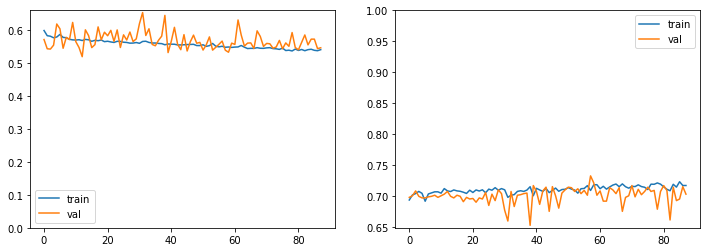

In [18]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6148 - accuracy: 0.6670 - precision: 0.7065 - recall: 0.5972 - f1: 0.6081 - specificity: 0.7207 - negative_predictive_value: 0.6563 - matthews_correlation_coefficient: 0.3432 - val_loss: 0.5733 - val_accuracy: 0.7095 - val_precision: 0.7151 - val_recall: 0.6295 - val_f1: 0.6632 - val_specificity: 0.7822 - val_negative_predictive_value: 0.6917 - val_matthews_correlation_coefficient: 0.4091

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.40906, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_29-02_47_12.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5658 - accuracy: 0.7165 - precision: 0.7264 - recall: 0.7305 - f1: 0.7104 - specificity: 0.7135 - negative_predictive_value: 0.7284 - matthews_correlation_coefficient: 0.4488 - val_loss: 0.5638 - val_accuracy: 0.7051 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4634 - accuracy: 0.7738 - precision: 0.7671 - recall: 0.7994 - f1: 0.7749 - specificity: 0.7482 - negative_predictive_value: 0.7851 - matthews_correlation_coefficient: 0.5513 - val_loss: 0.5317 - val_accuracy: 0.7372 - val_precision: 0.6583 - val_recall: 0.8765 - val_f1: 0.7456 - val_specificity: 0.5902 - val_negative_predictive_value: 0.8506 - val_matthews_correlation_coefficient: 0.4866

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.49787
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4725 - accuracy: 0.7618 - precision: 0.7614 - recall: 0.7745 - f1: 0.7585 - specificity: 0.7487 - negative_predictive_value: 0.7698 - matthews_correlation_coefficient: 0.5286 - val_loss: 0.4912 - val_accuracy: 0.7632 - val_precision: 0.7008 - val_recall: 0.8307 - val_f1: 0.7538 - val_specificity: 0.6891 - val_negative_predictive_value: 0.8233 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4457 - accuracy: 0.7733 - precision: 0.7711 - recall: 0.7772 - f1: 0.7645 - specificity: 0.7713 - negative_predictive_value: 0.7750 - matthews_correlation_coefficient: 0.5539 - val_loss: 0.4570 - val_accuracy: 0.7684 - val_precision: 0.7496 - val_recall: 0.7427 - val_f1: 0.7386 - val_specificity: 0.7895 - val_negative_predictive_value: 0.7687 - val_matthews_correlation_coefficient: 0.5251

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.53646
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4390 - accuracy: 0.7829 - precision: 0.7758 - recall: 0.7894 - f1: 0.7749 - specificity: 0.7750 - negative_predictive_value: 0.7875 - matthews_correlation_coefficient: 0.5637 - val_loss: 0.4707 - val_accuracy: 0.7771 - val_precision: 0.7432 - val_recall: 0.7769 - val_f1: 0.7525 - val_specificity: 0.7726 - val_negative_predictive_value: 0.7925 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4361 - accuracy: 0.7759 - precision: 0.7792 - recall: 0.7739 - f1: 0.7667 - specificity: 0.7794 - negative_predictive_value: 0.7839 - matthews_correlation_coefficient: 0.5597 - val_loss: 0.4576 - val_accuracy: 0.7736 - val_precision: 0.7820 - val_recall: 0.7010 - val_f1: 0.7329 - val_specificity: 0.8396 - val_negative_predictive_value: 0.7499 - val_matthews_correlation_coefficient: 0.5359

Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.54425
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4287 - accuracy: 0.7863 - precision: 0.7835 - recall: 0.7857 - f1: 0.7763 - specificity: 0.7848 - negative_predictive_value: 0.7927 - matthews_correlation_coefficient: 0.5747 - val_loss: 0.4675 - val_accuracy: 0.7632 - val_precision: 0.7864 - val_recall: 0.6716 - val_f1: 0.7184 - val_specificity: 0.8500 - val_negative_predictive_value: 0.7305 - val_matthews_correlation_coefficie


Epoch 00056: val_matthews_correlation_coefficient did not improve from 0.56402
Epoch 57/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4084 - accuracy: 0.7970 - precision: 0.8002 - recall: 0.8074 - f1: 0.7968 - specificity: 0.7931 - negative_predictive_value: 0.8053 - matthews_correlation_coefficient: 0.6029 - val_loss: 0.4577 - val_accuracy: 0.7797 - val_precision: 0.7723 - val_recall: 0.7357 - val_f1: 0.7469 - val_specificity: 0.8205 - val_negative_predictive_value: 0.7679 - val_matthews_correlation_coefficient: 0.5479

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.56402
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4076 - accuracy: 0.8009 - precision: 0.8034 - recall: 0.8064 - f1: 0.7959 - specificity: 0.7952 - negative_predictive_value: 0.8008 - matthews_correlation_coefficient: 0.6042 - val_loss: 0.4581 - val_accuracy: 0.7875 - val_precision: 0.7849 - val_recall: 0.7359 - val_f1: 0.7532 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3994 - accuracy: 0.8128 - precision: 0.8123 - recall: 0.8256 - f1: 0.8115 - specificity: 0.8061 - negative_predictive_value: 0.8225 - matthews_correlation_coefficient: 0.6329 - val_loss: 0.4457 - val_accuracy: 0.7754 - val_precision: 0.8045 - val_recall: 0.6809 - val_f1: 0.7307 - val_specificity: 0.8614 - val_negative_predictive_value: 0.7401 - val_matthews_correlation_coefficient: 0.5429

Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.58942
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4033 - accuracy: 0.8046 - precision: 0.8110 - recall: 0.8008 - f1: 0.7984 - specificity: 0.8043 - negative_predictive_value: 0.7989 - matthews_correlation_coefficient: 0.6090 - val_loss: 0.4423 - val_accuracy: 0.7814 - val_precision: 0.7741 - val_recall: 0.7328 - val_f1: 0.7471 - val_specificity: 0.8232 - val_negative_predictive_value: 0.7674 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3924 - accuracy: 0.8091 - precision: 0.8107 - recall: 0.8189 - f1: 0.8070 - specificity: 0.7999 - negative_predictive_value: 0.8093 - matthews_correlation_coefficient: 0.6191 - val_loss: 0.4369 - val_accuracy: 0.8049 - val_precision: 0.7972 - val_recall: 0.7589 - val_f1: 0.7708 - val_specificity: 0.8414 - val_negative_predictive_value: 0.7930 - val_matthews_correlation_coefficient: 0.5949

Epoch 00086: val_matthews_correlation_coefficient improved from 0.58942 to 0.59490, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_29-02_47_12.h5
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3825 - accuracy: 0.8174 - precision: 0.8230 - recall: 0.8214 - f1: 0.8173 - specificity: 0.8184 - negative_predictive_value: 0.8178 - matthews_correlation_coefficient: 0.6402 - val_loss: 0.4295 - val_accuracy: 0.7944 - val_precision: 0.7659 - val_recall: 0.7875 - val_f1: 0.76


Epoch 00100: val_matthews_correlation_coefficient did not improve from 0.59490

   Final Accuracy:  79.97%
  Final Precision:  77.32%
     Final Recall:  84.95%
  Final F-measure:  80.96%
Final Specificity:  74.96%
        Final NPV:  83.20%
        Final MCC:  60.22%
[[431 144]
 [ 87 491]]
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       575
           1       0.77      0.85      0.81       578

    accuracy                           0.80      1153
   macro avg       0.80      0.80      0.80      1153
weighted avg       0.80      0.80      0.80      1153



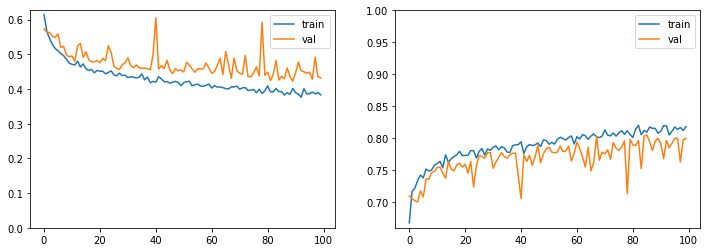

In [19]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6467 - accuracy: 0.5286 - precision: 0.8887 - recall: 0.4548 - f1: 0.5885 - specificity: 0.7887 - negative_predictive_value: 0.2887 - matthews_correlation_coefficient: 0.2121 - val_loss: 0.6714 - val_accuracy: 0.5247 - val_precision: 0.9135 - val_recall: 0.4489 - val_f1: 0.5928 - val_specificity: 0.8290 - val_negative_predictive_value: 0.2854 - val_matthews_correlation_coefficient: 0.2336

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.23360, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_29-03_02_02.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6312 - accuracy: 0.5555 - precision: 0.8974 - recall: 0.4865 - f1: 0.6205 - specificity: 0.7877 - negative_predictive_value: 0.2962 - matthews_correlation_coefficient: 0.2361 - val_loss: 0.6841 - val_accuracy: 0.5299 - val_precision: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5790 - accuracy: 0.6505 - precision: 0.9212 - recall: 0.6103 - f1: 0.7257 - specificity: 0.8061 - negative_predictive_value: 0.3637 - matthews_correlation_coefficient: 0.3422 - val_loss: 0.5478 - val_accuracy: 0.6886 - val_precision: 0.9001 - val_recall: 0.6891 - val_f1: 0.7768 - val_specificity: 0.6951 - val_negative_predictive_value: 0.3729 - val_matthews_correlation_coefficient: 0.3225

Epoch 00015: val_matthews_correlation_coefficient improved from 0.30673 to 0.32249, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_29-03_02_02.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5723 - accuracy: 0.6664 - precision: 0.9153 - recall: 0.6409 - f1: 0.7436 - specificity: 0.7573 - negative_predictive_value: 0.3717 - matthews_correlation_coefficient: 0.3356 - val_loss: 0.5412 - val_accuracy: 0.7069 - val_precision: 0.8864 - val_recall: 0.7301 - val_f1: 0.7967 - val_specifi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5599 - accuracy: 0.6679 - precision: 0.9248 - recall: 0.6384 - f1: 0.7434 - specificity: 0.7876 - negative_predictive_value: 0.3816 - matthews_correlation_coefficient: 0.3598 - val_loss: 0.5166 - val_accuracy: 0.7259 - val_precision: 0.8976 - val_recall: 0.7452 - val_f1: 0.8109 - val_specificity: 0.6653 - val_negative_predictive_value: 0.4099 - val_matthews_correlation_coefficient: 0.3540

Epoch 00029: val_matthews_correlation_coefficient improved from 0.34893 to 0.35401, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_29-03_02_02.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5311 - accuracy: 0.7061 - precision: 0.9218 - recall: 0.6742 - f1: 0.7737 - specificity: 0.7998 - negative_predictive_value: 0.4109 - matthews_correlation_coefficient: 0.3934 - val_loss: 0.5415 - val_accuracy: 0.7008 - val_precision: 0.9204 - val_recall: 0.6864 - val_f1: 0.7825 - val_specifi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5148 - accuracy: 0.7121 - precision: 0.9230 - recall: 0.6965 - f1: 0.7883 - specificity: 0.7852 - negative_predictive_value: 0.4244 - matthews_correlation_coefficient: 0.4076 - val_loss: 0.5551 - val_accuracy: 0.6904 - val_precision: 0.9221 - val_recall: 0.6728 - val_f1: 0.7738 - val_specificity: 0.7645 - val_negative_predictive_value: 0.3816 - val_matthews_correlation_coefficient: 0.3630

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.37901
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5196 - accuracy: 0.7048 - precision: 0.9190 - recall: 0.6836 - f1: 0.7766 - specificity: 0.7771 - negative_predictive_value: 0.4058 - matthews_correlation_coefficient: 0.3859 - val_loss: 0.5111 - val_accuracy: 0.7216 - val_precision: 0.9211 - val_recall: 0.7162 - val_f1: 0.8022 - val_specificity: 0.7467 - val_negative_predictive_value: 0.4125 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.39135
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5083 - accuracy: 0.7095 - precision: 0.9270 - recall: 0.6856 - f1: 0.7804 - specificity: 0.7991 - negative_predictive_value: 0.4206 - matthews_correlation_coefficient: 0.4083 - val_loss: 0.6238 - val_accuracy: 0.6583 - val_precision: 0.9275 - val_recall: 0.6238 - val_f1: 0.7412 - val_specificity: 0.7973 - val_negative_predictive_value: 0.3585 - val_matthews_correlation_coefficient: 0.3457

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.39135
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5142 - accuracy: 0.7095 - precision: 0.9248 - recall: 0.6882 - f1: 0.7814 - specificity: 0.7929 - negative_predictive_value: 0.4124 - matthews_correlation_coefficient: 0.4017 - val_loss: 0.6541 - val_accuracy: 0.6314 - val_precision: 0.9279 - val_recall: 0.5867 - val_f1: 0.7124 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.39135
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4925 - accuracy: 0.7304 - precision: 0.9282 - recall: 0.7148 - f1: 0.8027 - specificity: 0.7961 - negative_predictive_value: 0.4357 - matthews_correlation_coefficient: 0.4277 - val_loss: 0.5230 - val_accuracy: 0.7138 - val_precision: 0.9042 - val_recall: 0.7197 - val_f1: 0.7980 - val_specificity: 0.7021 - val_negative_predictive_value: 0.4015 - val_matthews_correlation_coefficient: 0.3578

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.39135
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4966 - accuracy: 0.7226 - precision: 0.9270 - recall: 0.7065 - f1: 0.7954 - specificity: 0.7887 - negative_predictive_value: 0.4336 - matthews_correlation_coefficient: 0.4193 - val_loss: 0.5590 - val_accuracy: 0.6930 - val_precision: 0.8979 - val_recall: 0.6982 - val_f1: 0.7823 - val_spe

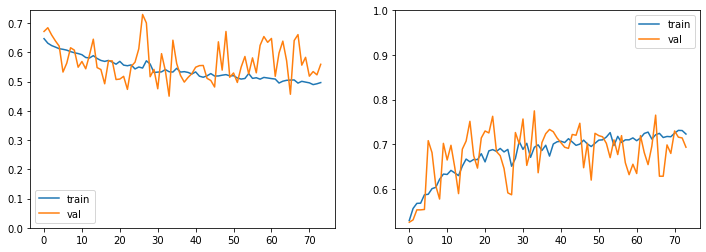

In [20]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4486 - accuracy: 0.7792 - precision: 0.8655 - recall: 0.7705 - f1: 0.8071 - specificity: 0.7957 - negative_predictive_value: 0.6701 - matthews_correlation_coefficient: 0.5536 - val_loss: 0.4423 - val_accuracy: 0.7658 - val_precision: 0.8752 - val_recall: 0.6865 - val_f1: 0.7664 - val_specificity: 0.8662 - val_negative_predictive_value: 0.6391 - val_matthews_correlation_coefficient: 0.5321

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.53212, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_29-03_13_14.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3974 - accuracy: 0.7961 - precision: 0.9055 - recall: 0.7609 - f1: 0.8217 - specificity: 0.8705 - negative_predictive_value: 0.6790 - matthews_correlation_coefficient: 0.6063 - val_loss: 0.4344 - val_accuracy: 0.7719 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.64212
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3234 - accuracy: 0.8553 - precision: 0.9257 - recall: 0.8290 - f1: 0.8713 - specificity: 0.8966 - negative_predictive_value: 0.7580 - matthews_correlation_coefficient: 0.7054 - val_loss: 0.3585 - val_accuracy: 0.8309 - val_precision: 0.8858 - val_recall: 0.7919 - val_f1: 0.8334 - val_specificity: 0.8653 - val_negative_predictive_value: 0.7341 - val_matthews_correlation_coefficient: 0.6375

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.64212
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3327 - accuracy: 0.8438 - precision: 0.9219 - recall: 0.8266 - f1: 0.8668 - specificity: 0.8732 - negative_predictive_value: 0.7454 - matthews_correlation_coefficient: 0.6821 - val_loss: 0.3631 - val_accuracy: 0.8231 - val_precision: 0.8339 - val_recall: 0.8412 - val_f1: 0.8355 - val_spe


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.69506
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3023 - accuracy: 0.8662 - precision: 0.9294 - recall: 0.8589 - f1: 0.8878 - specificity: 0.8826 - negative_predictive_value: 0.7815 - matthews_correlation_coefficient: 0.7252 - val_loss: 0.3253 - val_accuracy: 0.8491 - val_precision: 0.8428 - val_recall: 0.8744 - val_f1: 0.8562 - val_specificity: 0.7700 - val_negative_predictive_value: 0.8198 - val_matthews_correlation_coefficient: 0.6526

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.69506
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2948 - accuracy: 0.8707 - precision: 0.9293 - recall: 0.8648 - f1: 0.8928 - specificity: 0.8786 - negative_predictive_value: 0.7872 - matthews_correlation_coefficient: 0.7289 - val_loss: 0.3402 - val_accuracy: 0.8448 - val_precision: 0.8452 - val_recall: 0.8620 - val_f1: 0.8513 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2810 - accuracy: 0.8822 - precision: 0.9269 - recall: 0.8864 - f1: 0.9019 - specificity: 0.8813 - negative_predictive_value: 0.8260 - matthews_correlation_coefficient: 0.7590 - val_loss: 0.3647 - val_accuracy: 0.8534 - val_precision: 0.9416 - val_recall: 0.7745 - val_f1: 0.8464 - val_specificity: 0.9582 - val_negative_predictive_value: 0.7394 - val_matthews_correlation_coefficient: 0.7053

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.72153
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2737 - accuracy: 0.8831 - precision: 0.9226 - recall: 0.8803 - f1: 0.8978 - specificity: 0.8792 - negative_predictive_value: 0.8116 - matthews_correlation_coefficient: 0.7529 - val_loss: 0.3539 - val_accuracy: 0.8474 - val_precision: 0.9344 - val_recall: 0.7712 - val_f1: 0.8413 - val_specificity: 0.9445 - val_negative_predictive_value: 0.7336 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.73674
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2575 - accuracy: 0.8911 - precision: 0.9345 - recall: 0.8888 - f1: 0.9079 - specificity: 0.8926 - negative_predictive_value: 0.8193 - matthews_correlation_coefficient: 0.7686 - val_loss: 0.2982 - val_accuracy: 0.8777 - val_precision: 0.9279 - val_recall: 0.8274 - val_f1: 0.8715 - val_specificity: 0.9231 - val_negative_predictive_value: 0.7913 - val_matthews_correlation_coefficient: 0.7341

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.73674
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2594 - accuracy: 0.8937 - precision: 0.9397 - recall: 0.8921 - f1: 0.9118 - specificity: 0.9000 - negative_predictive_value: 0.8323 - matthews_correlation_coefficient: 0.7810 - val_loss: 0.3953 - val_accuracy: 0.8187 - val_precision: 0.9448 - val_recall: 0.7149 - val_f1: 0.8092 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.74556
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2470 - accuracy: 0.8959 - precision: 0.9365 - recall: 0.8969 - f1: 0.9141 - specificity: 0.8898 - negative_predictive_value: 0.8292 - matthews_correlation_coefficient: 0.7754 - val_loss: 0.3070 - val_accuracy: 0.8777 - val_precision: 0.9068 - val_recall: 0.8478 - val_f1: 0.8735 - val_specificity: 0.8960 - val_negative_predictive_value: 0.8074 - val_matthews_correlation_coefficient: 0.7280

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.74556
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2413 - accuracy: 0.8974 - precision: 0.9319 - recall: 0.9014 - f1: 0.9130 - specificity: 0.8924 - negative_predictive_value: 0.8324 - matthews_correlation_coefficient: 0.7799 - val_loss: 0.3454 - val_accuracy: 0.8560 - val_precision: 0.9245 - val_recall: 0.7940 - val_f1: 0.8510 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2330 - accuracy: 0.9033 - precision: 0.9393 - recall: 0.9080 - f1: 0.9209 - specificity: 0.8933 - negative_predictive_value: 0.8440 - matthews_correlation_coefficient: 0.7915 - val_loss: 0.2594 - val_accuracy: 0.9020 - val_precision: 0.8974 - val_recall: 0.8982 - val_f1: 0.8956 - val_specificity: 0.8704 - val_negative_predictive_value: 0.8776 - val_matthews_correlation_coefficient: 0.7710

Epoch 00087: val_matthews_correlation_coefficient improved from 0.76878 to 0.77103, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_29-03_13_14.h5
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2262 - accuracy: 0.9074 - precision: 0.9393 - recall: 0.9129 - f1: 0.9237 - specificity: 0.9021 - negative_predictive_value: 0.8582 - matthews_correlation_coefficient: 0.8055 - val_loss: 0.2941 - val_accuracy: 0.8838 - val_precision: 0.8783 - val_recall: 0.8905 - val_f1: 0.8823 - 

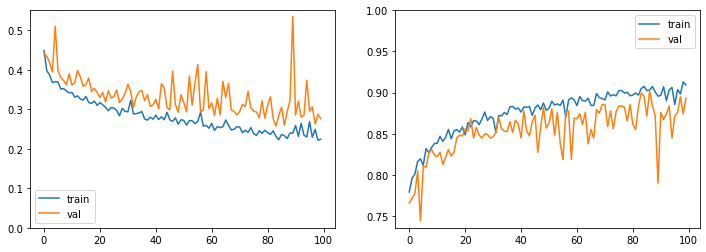

In [21]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5796 - accuracy: 0.6837 - precision: 0.8033 - recall: 0.6829 - f1: 0.7180 - specificity: 0.6980 - negative_predictive_value: 0.5730 - matthews_correlation_coefficient: 0.3796 - val_loss: 0.5542 - val_accuracy: 0.6982 - val_precision: 0.7912 - val_recall: 0.6546 - val_f1: 0.7122 - val_specificity: 0.7412 - val_negative_predictive_value: 0.5803 - val_matthews_correlation_coefficient: 0.3829

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.38291, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_29-03_28_21.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5269 - accuracy: 0.7258 - precision: 0.8160 - recall: 0.7321 - f1: 0.7650 - specificity: 0.7270 - negative_predictive_value: 0.6221 - matthews_correlation_coefficient: 0.4479 - val_loss: 0.5265 - val_accuracy: 0.7242 - val_p


Epoch 00014: val_matthews_correlation_coefficient improved from 0.53094 to 0.56476, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_29-03_28_21.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4538 - accuracy: 0.7946 - precision: 0.8571 - recall: 0.8107 - f1: 0.8261 - specificity: 0.7593 - negative_predictive_value: 0.7155 - matthews_correlation_coefficient: 0.5722 - val_loss: 0.4298 - val_accuracy: 0.7901 - val_precision: 0.7978 - val_recall: 0.8365 - val_f1: 0.8124 - val_specificity: 0.6711 - val_negative_predictive_value: 0.7278 - val_matthews_correlation_coefficient: 0.5159

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.56476
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4548 - accuracy: 0.7911 - precision: 0.8539 - recall: 0.7961 - f1: 0.8185 - specificity: 0.7730 - negative_predictive_value: 0.7012 - matthews_correlation_coefficient: 0.5630 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4268 - accuracy: 0.8152 - precision: 0.8738 - recall: 0.8257 - f1: 0.8442 - specificity: 0.7955 - negative_predictive_value: 0.7383 - matthews_correlation_coefficient: 0.6158 - val_loss: 0.4110 - val_accuracy: 0.8265 - val_precision: 0.8451 - val_recall: 0.8352 - val_f1: 0.8368 - val_specificity: 0.7636 - val_negative_predictive_value: 0.7499 - val_matthews_correlation_coefficient: 0.5964

Epoch 00029: val_matthews_correlation_coefficient improved from 0.58125 to 0.59644, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_29-03_28_21.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4257 - accuracy: 0.8148 - precision: 0.8723 - recall: 0.8274 - f1: 0.8432 - specificity: 0.7974 - negative_predictive_value: 0.7366 - matthews_correlation_coefficient: 0.6177 - val_loss: 0.4032 - val_accuracy: 0.8196 - val_precision: 0.8350 - val_recall: 0.8355 - val_f1: 0.8316 - 


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.60078
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4052 - accuracy: 0.8252 - precision: 0.8803 - recall: 0.8385 - f1: 0.8541 - specificity: 0.8121 - negative_predictive_value: 0.7545 - matthews_correlation_coefficient: 0.6416 - val_loss: 0.5144 - val_accuracy: 0.7572 - val_precision: 0.8392 - val_recall: 0.7108 - val_f1: 0.7654 - val_specificity: 0.7925 - val_negative_predictive_value: 0.6446 - val_matthews_correlation_coefficient: 0.4934

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.60078
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4019 - accuracy: 0.8312 - precision: 0.8800 - recall: 0.8358 - f1: 0.8532 - specificity: 0.8182 - negative_predictive_value: 0.7526 - matthews_correlation_coefficient: 0.6443 - val_loss: 0.4035 - val_accuracy: 0.8092 - val_precision: 0.7986 - val_recall: 0.8675 - val_f1: 0.8290 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3901 - accuracy: 0.8299 - precision: 0.8813 - recall: 0.8487 - f1: 0.8594 - specificity: 0.8028 - negative_predictive_value: 0.7615 - matthews_correlation_coefficient: 0.6460 - val_loss: 0.3941 - val_accuracy: 0.8413 - val_precision: 0.8693 - val_recall: 0.8284 - val_f1: 0.8452 - val_specificity: 0.8109 - val_negative_predictive_value: 0.7552 - val_matthews_correlation_coefficient: 0.6314

Epoch 00058: val_matthews_correlation_coefficient improved from 0.61113 to 0.63143, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_29-03_28_21.h5
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3878 - accuracy: 0.8388 - precision: 0.8913 - recall: 0.8488 - f1: 0.8649 - specificity: 0.8211 - negative_predictive_value: 0.7636 - matthews_correlation_coefficient: 0.6631 - val_loss: 0.3827 - val_accuracy: 0.8343 - val_precision: 0.8136 - val_recall: 0.8897 - val_f1: 0.8480 - 


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.63143
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3909 - accuracy: 0.8360 - precision: 0.8849 - recall: 0.8503 - f1: 0.8623 - specificity: 0.8123 - negative_predictive_value: 0.7643 - matthews_correlation_coefficient: 0.6567 - val_loss: 0.3850 - val_accuracy: 0.8248 - val_precision: 0.8029 - val_recall: 0.8909 - val_f1: 0.8421 - val_specificity: 0.6698 - val_negative_predictive_value: 0.8053 - val_matthews_correlation_coefficient: 0.5834

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.63143
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3826 - accuracy: 0.8384 - precision: 0.8854 - recall: 0.8543 - f1: 0.8651 - specificity: 0.8072 - negative_predictive_value: 0.7696 - matthews_correlation_coefficient: 0.6591 - val_loss: 0.3813 - val_accuracy: 0.8378 - val_precision: 0.8515 - val_recall: 0.8440 - val_f1: 0.8452 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.63143
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3811 - accuracy: 0.8425 - precision: 0.8870 - recall: 0.8642 - f1: 0.8707 - specificity: 0.8136 - negative_predictive_value: 0.7821 - matthews_correlation_coefficient: 0.6722 - val_loss: 0.3722 - val_accuracy: 0.8439 - val_precision: 0.8421 - val_recall: 0.8649 - val_f1: 0.8515 - val_specificity: 0.7569 - val_negative_predictive_value: 0.7846 - val_matthews_correlation_coefficient: 0.6241
Restoring model weights from the end of the best epoch

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.63143
Epoch 00088: early stopping

   Final Accuracy:  84.13%
  Final Precision:  89.11%
     Final Recall:  85.04%
  Final F-measure:  87.03%
Final Specificity:  82.60%
        Final NPV:  76.72%
        Final MCC:  66.73%
[[356  75]
 [108 614]]
              precision    recall  f1-score   support

           0     

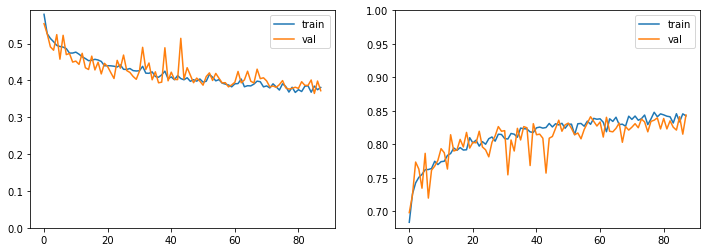

In [22]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5830 - accuracy: 0.5458 - precision: 0.9671 - recall: 0.5119 - f1: 0.6608 - specificity: 0.8452 - negative_predictive_value: 0.1871 - matthews_correlation_coefficient: 0.2306 - val_loss: 0.7048 - val_accuracy: 0.4449 - val_precision: 0.9574 - val_recall: 0.3691 - val_f1: 0.5279 - val_specificity: 0.9379 - val_negative_predictive_value: 0.1836 - val_matthews_correlation_coefficient: 0.2068

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.20684, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_29-03_41_29.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5708 - accuracy: 0.5312 - precision: 0.9668 - recall: 0.4917 - f1: 0.6395 - specificity: 0.8195 - negative_predictive_value: 0.1817 - matthews_correlation_coefficient: 0.2116 - val_loss: 0.5429 - val_accuracy: 0.5776 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.37307
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4672 - accuracy: 0.7306 - precision: 0.9732 - recall: 0.7179 - f1: 0.8181 - specificity: 0.8248 - negative_predictive_value: 0.2924 - matthews_correlation_coefficient: 0.3706 - val_loss: 0.7291 - val_accuracy: 0.5846 - val_precision: 0.9558 - val_recall: 0.5270 - val_f1: 0.6753 - val_specificity: 0.8672 - val_negative_predictive_value: 0.1990 - val_matthews_correlation_coefficient: 0.2740

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.37307
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4553 - accuracy: 0.7336 - precision: 0.9715 - recall: 0.7249 - f1: 0.8242 - specificity: 0.8140 - negative_predictive_value: 0.2902 - matthews_correlation_coefficient: 0.3648 - val_loss: 0.3526 - val_accuracy: 0.8361 - val_precision: 0.9299 - val_recall: 0.8337 - val_f1: 0.8778 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4014 - accuracy: 0.7655 - precision: 0.9786 - recall: 0.7549 - f1: 0.8446 - specificity: 0.8480 - negative_predictive_value: 0.3336 - matthews_correlation_coefficient: 0.4231 - val_loss: 0.3705 - val_accuracy: 0.8023 - val_precision: 0.9502 - val_recall: 0.7765 - val_f1: 0.8521 - val_specificity: 0.7862 - val_negative_predictive_value: 0.3368 - val_matthews_correlation_coefficient: 0.4218

Epoch 00029: val_matthews_correlation_coefficient improved from 0.40947 to 0.42182, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_29-03_41_29.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4376 - accuracy: 0.7397 - precision: 0.9751 - recall: 0.7300 - f1: 0.8247 - specificity: 0.8286 - negative_predictive_value: 0.3063 - matthews_correlation_coefficient: 0.3868 - val_loss: 0.7702 - val_accuracy: 0.5663 - val_precision: 0.9658 - val_recall: 0.5010 - val_f1: 0.6543 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3606 - accuracy: 0.7941 - precision: 0.9807 - recall: 0.7828 - f1: 0.8668 - specificity: 0.8456 - negative_predictive_value: 0.3503 - matthews_correlation_coefficient: 0.4505 - val_loss: 0.5134 - val_accuracy: 0.7164 - val_precision: 0.9634 - val_recall: 0.6689 - val_f1: 0.7868 - val_specificity: 0.9274 - val_negative_predictive_value: 0.2930 - val_matthews_correlation_coefficient: 0.3827

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.45192
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3851 - accuracy: 0.7790 - precision: 0.9786 - recall: 0.7689 - f1: 0.8550 - specificity: 0.8388 - negative_predictive_value: 0.3393 - matthews_correlation_coefficient: 0.4316 - val_loss: 0.5628 - val_accuracy: 0.6817 - val_precision: 0.9646 - val_recall: 0.6292 - val_f1: 0.7578 - val_specificity: 0.9315 - val_negative_predictive_value: 0.2707 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3494 - accuracy: 0.8011 - precision: 0.9820 - recall: 0.7937 - f1: 0.8736 - specificity: 0.8469 - negative_predictive_value: 0.3720 - matthews_correlation_coefficient: 0.4698 - val_loss: 0.5533 - val_accuracy: 0.7008 - val_precision: 0.9650 - val_recall: 0.6508 - val_f1: 0.7734 - val_specificity: 0.9290 - val_negative_predictive_value: 0.2866 - val_matthews_correlation_coefficient: 0.3738

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.45192
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3641 - accuracy: 0.8020 - precision: 0.9805 - recall: 0.7916 - f1: 0.8703 - specificity: 0.8549 - negative_predictive_value: 0.3820 - matthews_correlation_coefficient: 0.4728 - val_loss: 0.5562 - val_accuracy: 0.7016 - val_precision: 0.9663 - val_recall: 0.6504 - val_f1: 0.7736 - val_specificity: 0.9396 - val_negative_predictive_value: 0.2878 - val_matthews_correlation_coefficie

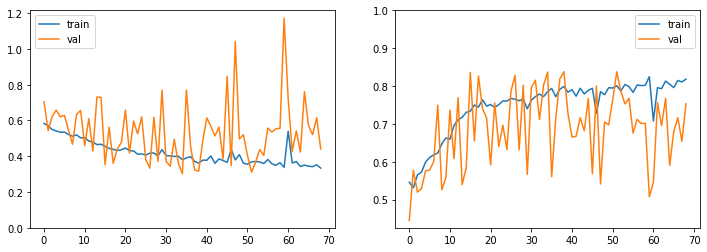

In [23]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5820 - accuracy: 0.6636 - precision: 0.9095 - recall: 0.6450 - f1: 0.7458 - specificity: 0.7397 - negative_predictive_value: 0.3405 - matthews_correlation_coefficient: 0.3117 - val_loss: 0.5366 - val_accuracy: 0.7129 - val_precision: 0.8910 - val_recall: 0.7413 - val_f1: 0.8052 - val_specificity: 0.6138 - val_negative_predictive_value: 0.3711 - val_matthews_correlation_coefficient: 0.3037

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.30368, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_29-03_51_50.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5726 - accuracy: 0.6879 - precision: 0.9103 - recall: 0.6764 - f1: 0.7689 - specificity: 0.7357 - negative_predictive_value: 0.3773 - matthews_correlation_coefficient: 0.3416 - val_loss: 0.6502 - val_accuracy: 0.6297 -

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5198 - accuracy: 0.7108 - precision: 0.9179 - recall: 0.6981 - f1: 0.7873 - specificity: 0.7539 - negative_predictive_value: 0.3982 - matthews_correlation_coefficient: 0.3764 - val_loss: 0.6161 - val_accuracy: 0.5993 - val_precision: 0.9451 - val_recall: 0.5384 - val_f1: 0.6774 - val_specificity: 0.8636 - val_negative_predictive_value: 0.3237 - val_matthews_correlation_coefficient: 0.3268

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.34148
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5187 - accuracy: 0.7089 - precision: 0.9208 - recall: 0.6978 - f1: 0.7880 - specificity: 0.7718 - negative_predictive_value: 0.4075 - matthews_correlation_coefficient: 0.3891 - val_loss: 0.5729 - val_accuracy: 0.6652 - val_precision: 0.9337 - val_recall: 0.6336 - val_f1: 0.7501 - val_specificity: 0.8036 - val_negative_predictive_value: 0.3591 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5034 - accuracy: 0.7254 - precision: 0.9282 - recall: 0.7101 - f1: 0.7965 - specificity: 0.7610 - negative_predictive_value: 0.4243 - matthews_correlation_coefficient: 0.4040 - val_loss: 0.5615 - val_accuracy: 0.7103 - val_precision: 0.9277 - val_recall: 0.7001 - val_f1: 0.7933 - val_specificity: 0.7644 - val_negative_predictive_value: 0.3953 - val_matthews_correlation_coefficient: 0.3854

Epoch 00029: val_matthews_correlation_coefficient improved from 0.37944 to 0.38536, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_29-03_51_50.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4941 - accuracy: 0.7325 - precision: 0.9220 - recall: 0.7232 - f1: 0.8040 - specificity: 0.7564 - negative_predictive_value: 0.4267 - matthews_correlation_coefficient: 0.4071 - val_loss: 0.5221 - val_accuracy: 0.7251 - val_precision: 0.9227 - val_recall: 0.7260 - val_f1: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4837 - accuracy: 0.7436 - precision: 0.9255 - recall: 0.7407 - f1: 0.8166 - specificity: 0.7574 - negative_predictive_value: 0.4400 - matthews_correlation_coefficient: 0.4229 - val_loss: 0.5332 - val_accuracy: 0.6947 - val_precision: 0.9234 - val_recall: 0.6812 - val_f1: 0.7809 - val_specificity: 0.7618 - val_negative_predictive_value: 0.3772 - val_matthews_correlation_coefficient: 0.3632

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.39610
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4752 - accuracy: 0.7538 - precision: 0.9324 - recall: 0.7454 - f1: 0.8230 - specificity: 0.7818 - negative_predictive_value: 0.4581 - matthews_correlation_coefficient: 0.4512 - val_loss: 0.6451 - val_accuracy: 0.6028 - val_precision: 0.9501 - val_recall: 0.5393 - val_f1: 0.6822 - val_specificity: 0.8760 - val_negative_predictive_value: 0.3244 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.40035
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4628 - accuracy: 0.7575 - precision: 0.9299 - recall: 0.7499 - f1: 0.8259 - specificity: 0.7658 - negative_predictive_value: 0.4522 - matthews_correlation_coefficient: 0.4424 - val_loss: 0.5345 - val_accuracy: 0.6912 - val_precision: 0.9249 - val_recall: 0.6764 - val_f1: 0.7767 - val_specificity: 0.7690 - val_negative_predictive_value: 0.3788 - val_matthews_correlation_coefficient: 0.3660

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.40035
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4738 - accuracy: 0.7562 - precision: 0.9314 - recall: 0.7522 - f1: 0.8253 - specificity: 0.7714 - negative_predictive_value: 0.4693 - matthews_correlation_coefficient: 0.4522 - val_loss: 0.7167 - val_accuracy: 0.5785 - val_precision: 0.9493 - val_recall: 0.5092 - val_f1: 0.6535 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.40035
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4544 - accuracy: 0.7620 - precision: 0.9254 - recall: 0.7513 - f1: 0.8213 - specificity: 0.7720 - negative_predictive_value: 0.4716 - matthews_correlation_coefficient: 0.4571 - val_loss: 0.5760 - val_accuracy: 0.6522 - val_precision: 0.9410 - val_recall: 0.6110 - val_f1: 0.7356 - val_specificity: 0.8321 - val_negative_predictive_value: 0.3530 - val_matthews_correlation_coefficient: 0.3592

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.40035
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4417 - accuracy: 0.7744 - precision: 0.9367 - recall: 0.7683 - f1: 0.8393 - specificity: 0.8010 - negative_predictive_value: 0.4807 - matthews_correlation_coefficient: 0.4839 - val_loss: 0.5318 - val_accuracy: 0.6947 - val_precision: 0.9286 - val_recall: 0.6767 - val_f1: 0.7790 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.40526
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4356 - accuracy: 0.7768 - precision: 0.9283 - recall: 0.7694 - f1: 0.8366 - specificity: 0.7786 - negative_predictive_value: 0.4835 - matthews_correlation_coefficient: 0.4791 - val_loss: 0.6665 - val_accuracy: 0.6193 - val_precision: 0.9474 - val_recall: 0.5642 - val_f1: 0.7003 - val_specificity: 0.8526 - val_negative_predictive_value: 0.3346 - val_matthews_correlation_coefficient: 0.3414

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.40526
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4333 - accuracy: 0.7766 - precision: 0.9374 - recall: 0.7741 - f1: 0.8422 - specificity: 0.7928 - negative_predictive_value: 0.4890 - matthews_correlation_coefficient: 0.4864 - val_loss: 0.5183 - val_accuracy: 0.7207 - val_precision: 0.9278 - val_recall: 0.7114 - val_f1: 0.8026 - val_spe

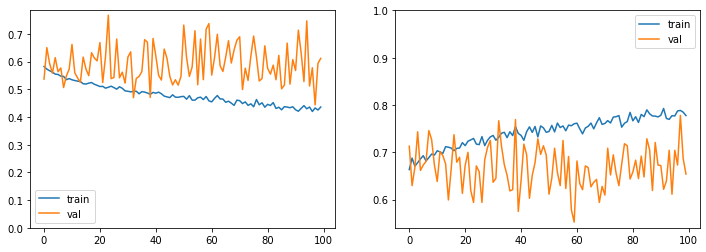

In [24]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5911 - accuracy: 0.7879 - precision: 0.9987 - recall: 0.7900 - f1: 0.8731 - specificity: 0.0621 - negative_predictive_value: 0.0067 - matthews_correlation_coefficient: 0.0169 - val_loss: 0.1556 - val_accuracy: 0.9670 - val_precision: 0.9983 - val_recall: 0.9695 - val_f1: 0.9833 - val_specificity: 0.0541 - val_negative_predictive_value: 0.0270 - val_matthews_correlation_coefficient: 0.0367

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.03673, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_29-04_06_50.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4883 - accuracy: 0.7336 - precision: 0.9989 - recall: 0.7358 - f1: 0.8349 - specificity: 0.0690 - negative_predictive_value: 0.0091 - matthews_correlation_coefficient: 0.0201 - val_loss: 0.1757 - val_accuracy: 0.9332 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1847 - accuracy: 0.8866 - precision: 1.0000 - recall: 0.8870 - f1: 0.9386 - specificity: 0.0897 - negative_predictive_value: 0.0359 - matthews_correlation_coefficient: 0.0514 - val_loss: 0.2155 - val_accuracy: 0.9020 - val_precision: 1.0000 - val_recall: 0.9043 - val_f1: 0.9488 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0414 - val_matthews_correlation_coefficient: 0.0640

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.07972
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1414 - accuracy: 0.9187 - precision: 1.0000 - recall: 0.9189 - f1: 0.9569 - specificity: 0.1034 - negative_predictive_value: 0.0365 - matthews_correlation_coefficient: 0.0571 - val_loss: 0.1910 - val_accuracy: 0.9228 - val_precision: 1.0000 - val_recall: 0.9247 - val_f1: 0.9602 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0473 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.09617
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1736 - accuracy: 0.8946 - precision: 1.0000 - recall: 0.8950 - f1: 0.9432 - specificity: 0.0966 - negative_predictive_value: 0.0311 - matthews_correlation_coefficient: 0.0514 - val_loss: 0.1824 - val_accuracy: 0.9237 - val_precision: 1.0000 - val_recall: 0.9255 - val_f1: 0.9606 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0428 - val_matthews_correlation_coefficient: 0.0655

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.09617
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1314 - accuracy: 0.9234 - precision: 1.0000 - recall: 0.9237 - f1: 0.9596 - specificity: 0.0966 - negative_predictive_value: 0.0402 - matthews_correlation_coefficient: 0.0575 - val_loss: 0.0629 - val_accuracy: 0.9679 - val_precision: 1.0000 - val_recall: 0.9687 - val_f1: 0.9837 - val_spe


Epoch 00044: val_matthews_correlation_coefficient improved from 0.09617 to 0.09988, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_29-04_06_50.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1748 - accuracy: 0.9100 - precision: 1.0000 - recall: 0.9103 - f1: 0.9508 - specificity: 0.1034 - negative_predictive_value: 0.0577 - matthews_correlation_coefficient: 0.0703 - val_loss: 0.2664 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.9186 - val_f1: 0.9567 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0473 - val_matthews_correlation_coefficient: 0.0651

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1281 - accuracy: 0.9328 - precision: 1.0000 - recall: 0.9330 - f1: 0.9647 - specificity: 0.0966 - negative_predictive_value: 0.0426 - matthews_correlation_coefficient: 0.0599 - val_loss: 0.13


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0976 - accuracy: 0.9538 - precision: 1.0000 - recall: 0.9540 - f1: 0.9760 - specificity: 0.1034 - negative_predictive_value: 0.0583 - matthews_correlation_coefficient: 0.0741 - val_loss: 0.1736 - val_accuracy: 0.9341 - val_precision: 1.0000 - val_recall: 0.9357 - val_f1: 0.9661 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0495 - val_matthews_correlation_coefficient: 0.0715

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0669 - accuracy: 0.9588 - precision: 1.0000 - recall: 0.9590 - f1: 0.9786 - specificity: 0.1034 - negative_predictive_value: 0.0713 - matthews_correlation_coefficient: 0.0827 - val_loss: 0.0510 - val_accuracy: 0.9792 - val_precision: 1.0000 - val_recall: 0.9797 - val_f1: 0.9895 - val_spe

Restoring model weights from the end of the best epoch

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 00074: early stopping

   Final Accuracy:  98.18%
  Final Precision: 100.00%
     Final Recall:  98.17%
  Final F-measure:  99.08%
Final Specificity: 100.00%
        Final NPV:  16.00%
        Final MCC:  39.63%
[[   4    0]
 [  21 1128]]
              precision    recall  f1-score   support

           0       0.16      1.00      0.28         4
           1       1.00      0.98      0.99      1149

    accuracy                           0.98      1153
   macro avg       0.58      0.99      0.63      1153
weighted avg       1.00      0.98      0.99      1153



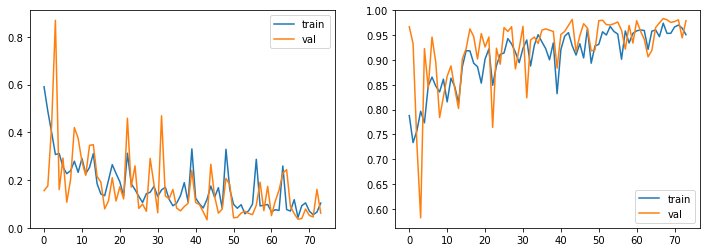

In [25]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6118 - accuracy: 0.6184 - precision: 0.8625 - recall: 0.5520 - f1: 0.6563 - specificity: 0.7789 - negative_predictive_value: 0.4261 - matthews_correlation_coefficient: 0.3071 - val_loss: 0.5922 - val_accuracy: 0.6600 - val_precision: 0.8646 - val_recall: 0.6334 - val_f1: 0.7242 - val_specificity: 0.7399 - val_negative_predictive_value: 0.4445 - val_matthews_correlation_coefficient: 0.3385

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.33846, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_29-04_18_08.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5901 - accuracy: 0.6252 - precision: 0.8866 - recall: 0.5476 - f1: 0.6658 - specificity: 0.8159 - negative_predictive_value: 0.4310 - matthews_correlation_coefficient: 0.3399 - val_loss: 0.5944 - val_accuracy: 0.6739 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5436 - accuracy: 0.6941 - precision: 0.8991 - recall: 0.6344 - f1: 0.7365 - specificity: 0.8320 - negative_predictive_value: 0.4891 - matthews_correlation_coefficient: 0.4305 - val_loss: 0.5441 - val_accuracy: 0.7103 - val_precision: 0.8994 - val_recall: 0.6768 - val_f1: 0.7669 - val_specificity: 0.7942 - val_negative_predictive_value: 0.4945 - val_matthews_correlation_coefficient: 0.4291

Epoch 00015: val_matthews_correlation_coefficient improved from 0.40066 to 0.42909, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_29-04_18_08.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5576 - accuracy: 0.6755 - precision: 0.8979 - recall: 0.6163 - f1: 0.7186 - specificity: 0.8249 - negative_predictive_value: 0.4762 - matthews_correlation_coefficient: 0.4062 - val_loss: 0.5201 - val_accuracy: 0.7077 - val_precision: 0.8243 - val_recall: 0.7620 - val_f1: 0.7870 - 


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.44143
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5239 - accuracy: 0.7082 - precision: 0.9023 - recall: 0.6646 - f1: 0.7583 - specificity: 0.8258 - negative_predictive_value: 0.5065 - matthews_correlation_coefficient: 0.4460 - val_loss: 0.5386 - val_accuracy: 0.7155 - val_precision: 0.9099 - val_recall: 0.6776 - val_f1: 0.7701 - val_specificity: 0.8081 - val_negative_predictive_value: 0.4997 - val_matthews_correlation_coefficient: 0.4443

Epoch 00030: val_matthews_correlation_coefficient improved from 0.44143 to 0.44430, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_29-04_18_08.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5129 - accuracy: 0.7210 - precision: 0.9115 - recall: 0.6734 - f1: 0.7671 - specificity: 0.8425 - negative_predictive_value: 0.5102 - matthews_correlation_coefficient: 0.4660 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5036 - accuracy: 0.7180 - precision: 0.9133 - recall: 0.6661 - f1: 0.7649 - specificity: 0.8390 - negative_predictive_value: 0.5099 - matthews_correlation_coefficient: 0.4621 - val_loss: 0.5070 - val_accuracy: 0.7389 - val_precision: 0.9054 - val_recall: 0.7172 - val_f1: 0.7954 - val_specificity: 0.7914 - val_negative_predictive_value: 0.5216 - val_matthews_correlation_coefficient: 0.4644

Epoch 00044: val_matthews_correlation_coefficient improved from 0.44717 to 0.46441, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_29-04_18_08.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5003 - accuracy: 0.7304 - precision: 0.9155 - recall: 0.6872 - f1: 0.7803 - specificity: 0.8466 - negative_predictive_value: 0.5308 - matthews_correlation_coefficient: 0.4866 - val_loss: 0.5236 - val_accuracy: 0.7216 - val_precision: 0.9147 - val_recall: 0.6829 - val_f1: 0.7757 - 


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.46441
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4957 - accuracy: 0.7312 - precision: 0.9039 - recall: 0.6949 - f1: 0.7790 - specificity: 0.8202 - negative_predictive_value: 0.5263 - matthews_correlation_coefficient: 0.4702 - val_loss: 0.5451 - val_accuracy: 0.7095 - val_precision: 0.9181 - val_recall: 0.6582 - val_f1: 0.7606 - val_specificity: 0.8361 - val_negative_predictive_value: 0.4919 - val_matthews_correlation_coefficient: 0.4484

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.46441
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4900 - accuracy: 0.7315 - precision: 0.9112 - recall: 0.6912 - f1: 0.7797 - specificity: 0.8331 - negative_predictive_value: 0.5308 - matthews_correlation_coefficient: 0.4796 - val_loss: 0.5156 - val_accuracy: 0.7277 - val_precision: 0.9003 - val_recall: 0.7027 - val_f1: 0.7845 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46441
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4801 - accuracy: 0.7447 - precision: 0.9189 - recall: 0.7057 - f1: 0.7928 - specificity: 0.8482 - negative_predictive_value: 0.5445 - matthews_correlation_coefficient: 0.5043 - val_loss: 0.6055 - val_accuracy: 0.6748 - val_precision: 0.9158 - val_recall: 0.6063 - val_f1: 0.7216 - val_specificity: 0.8407 - val_negative_predictive_value: 0.4588 - val_matthews_correlation_coefficient: 0.4073
Restoring model weights from the end of the best epoch

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.46441
Epoch 00074: early stopping

   Final Accuracy:  73.89%
  Final Precision:  90.02%
     Final Recall:  70.88%
  Final F-measure:  79.31%
Final Specificity:  81.12%
        Final NPV:  53.71%
        Final MCC:  47.69%
[[275  64]
 [237 577]]
              precision    recall  f1-score   support

           0     

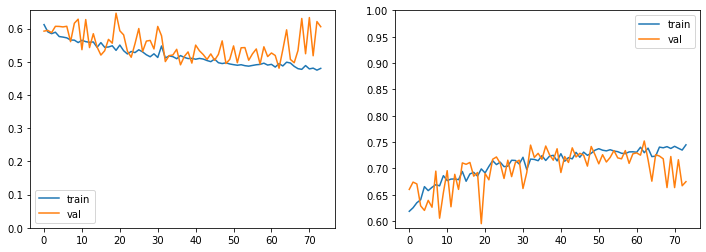

In [26]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5999 - accuracy: 0.5970 - precision: 0.9288 - recall: 0.5780 - f1: 0.6991 - specificity: 0.7209 - negative_predictive_value: 0.2337 - matthews_correlation_coefficient: 0.2172 - val_loss: 0.4735 - val_accuracy: 0.7138 - val_precision: 0.9247 - val_recall: 0.7339 - val_f1: 0.8150 - val_specificity: 0.6631 - val_negative_predictive_value: 0.2870 - val_matthews_correlation_coefficient: 0.2838

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28375, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_29-04_31_26.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5585 - accuracy: 0.6328 - precision: 0.9465 - recall: 0.6097 - f1: 0.7306 - specificity: 0.7645 - negative_predictive_value: 0.2625 - matthews_correlation_coefficient: 0.2794 - val_loss: 0.5203 - val_accuracy: 0.6765 - val_precision: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4935 - accuracy: 0.6879 - precision: 0.9606 - recall: 0.6620 - f1: 0.7734 - specificity: 0.8071 - negative_predictive_value: 0.2993 - matthews_correlation_coefficient: 0.3475 - val_loss: 0.4950 - val_accuracy: 0.7060 - val_precision: 0.9504 - val_recall: 0.7030 - val_f1: 0.8044 - val_specificity: 0.7785 - val_negative_predictive_value: 0.3028 - val_matthews_correlation_coefficient: 0.3429

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.37510
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4656 - accuracy: 0.7121 - precision: 0.9602 - recall: 0.6936 - f1: 0.7990 - specificity: 0.8366 - negative_predictive_value: 0.3231 - matthews_correlation_coefficient: 0.3870 - val_loss: 0.4293 - val_accuracy: 0.7572 - val_precision: 0.9443 - val_recall: 0.7683 - val_f1: 0.8449 - val_specificity: 0.7355 - val_negative_predictive_value: 0.3411 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.41476
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4376 - accuracy: 0.7512 - precision: 0.9654 - recall: 0.7400 - f1: 0.8334 - specificity: 0.8265 - negative_predictive_value: 0.3565 - matthews_correlation_coefficient: 0.4210 - val_loss: 0.3776 - val_accuracy: 0.7858 - val_precision: 0.9269 - val_recall: 0.8229 - val_f1: 0.8696 - val_specificity: 0.6177 - val_negative_predictive_value: 0.3469 - val_matthews_correlation_coefficient: 0.3395

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.41476
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4286 - accuracy: 0.7432 - precision: 0.9656 - recall: 0.7301 - f1: 0.8270 - specificity: 0.8256 - negative_predictive_value: 0.3552 - matthews_correlation_coefficient: 0.4172 - val_loss: 0.4856 - val_accuracy: 0.7025 - val_precision: 0.9658 - val_recall: 0.6840 - val_f1: 0.7977 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.43417
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4104 - accuracy: 0.7605 - precision: 0.9677 - recall: 0.7499 - f1: 0.8384 - specificity: 0.8217 - negative_predictive_value: 0.3685 - matthews_correlation_coefficient: 0.4306 - val_loss: 0.3167 - val_accuracy: 0.8526 - val_precision: 0.9204 - val_recall: 0.9114 - val_f1: 0.9145 - val_specificity: 0.5404 - val_negative_predictive_value: 0.4723 - val_matthews_correlation_coefficient: 0.4133

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.43417
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4032 - accuracy: 0.7766 - precision: 0.9675 - recall: 0.7647 - f1: 0.8491 - specificity: 0.8457 - negative_predictive_value: 0.3865 - matthews_correlation_coefficient: 0.4568 - val_loss: 0.3544 - val_accuracy: 0.8118 - val_precision: 0.9382 - val_recall: 0.8425 - val_f1: 0.8862 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.43417
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3998 - accuracy: 0.7822 - precision: 0.9633 - recall: 0.7754 - f1: 0.8542 - specificity: 0.8188 - negative_predictive_value: 0.3918 - matthews_correlation_coefficient: 0.4517 - val_loss: 0.4420 - val_accuracy: 0.7598 - val_precision: 0.9591 - val_recall: 0.7602 - val_f1: 0.8448 - val_specificity: 0.7938 - val_negative_predictive_value: 0.3547 - val_matthews_correlation_coefficient: 0.4098

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.43417
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3782 - accuracy: 0.7807 - precision: 0.9688 - recall: 0.7704 - f1: 0.8553 - specificity: 0.8460 - negative_predictive_value: 0.3900 - matthews_correlation_coefficient: 0.4633 - val_loss: 0.3451 - val_accuracy: 0.8257 - val_precision: 0.9372 - val_recall: 0.8606 - val_f1: 0.8955 - val_spe

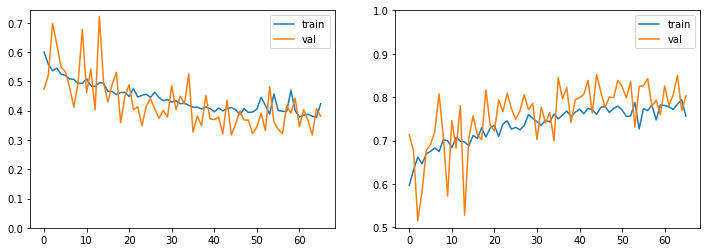

In [27]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4151 - accuracy: 0.7818 - precision: 0.9921 - recall: 0.7720 - f1: 0.8622 - specificity: 0.8027 - negative_predictive_value: 0.2278 - matthews_correlation_coefficient: 0.3544 - val_loss: 0.3807 - val_accuracy: 0.8387 - val_precision: 0.9643 - val_recall: 0.8136 - val_f1: 0.8811 - val_specificity: 0.7748 - val_negative_predictive_value: 0.2588 - val_matthews_correlation_coefficient: 0.3829

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.38286, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_29-04_41_45.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3224 - accuracy: 0.8698 - precision: 0.9917 - recall: 0.8666 - f1: 0.9230 - specificity: 0.7196 - negative_predictive_value: 0.3117 - matthews_correlation_coefficient: 0.4179 - val_loss: 0.4039 - val_accuracy: 0.8491 - val_precis


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2419 - accuracy: 0.9158 - precision: 0.9932 - recall: 0.9173 - f1: 0.9524 - specificity: 0.8023 - negative_predictive_value: 0.4604 - matthews_correlation_coefficient: 0.5620 - val_loss: 0.1886 - val_accuracy: 0.9376 - val_precision: 0.9635 - val_recall: 0.9180 - val_f1: 0.9398 - val_specificity: 0.7477 - val_negative_predictive_value: 0.4450 - val_matthews_correlation_coefficient: 0.5381

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2488 - accuracy: 0.9197 - precision: 0.9918 - recall: 0.9224 - f1: 0.9549 - specificity: 0.7823 - negative_predictive_value: 0.4400 - matthews_correlation_coefficient: 0.5401 - val_loss: 0.2038 - val_accuracy: 0.9384 - val_precision: 0.9635 - val_recall: 0.9189 - val_f1: 0.9402 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2005 - accuracy: 0.9386 - precision: 0.9939 - recall: 0.9377 - f1: 0.9638 - specificity: 0.7611 - negative_predictive_value: 0.5021 - matthews_correlation_coefficient: 0.5830 - val_loss: 0.1303 - val_accuracy: 0.9636 - val_precision: 0.9908 - val_recall: 0.9710 - val_f1: 0.9805 - val_specificity: 0.7658 - val_negative_predictive_value: 0.5948 - val_matthews_correlation_coefficient: 0.6447

Epoch 00029: val_matthews_correlation_coefficient improved from 0.59848 to 0.64469, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_29-04_41_45.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2301 - accuracy: 0.9278 - precision: 0.9891 - recall: 0.9306 - f1: 0.9568 - specificity: 0.7816 - negative_predictive_value: 0.4989 - matthews_correlation_coefficient: 0.5805 - val_loss: 0.3644 - val_accuracy: 0.8942 - val_precision: 0.9669 - val_recall: 0.8696 - val_f1: 0.9149 - val_s


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.64469
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1746 - accuracy: 0.9403 - precision: 0.9942 - recall: 0.9425 - f1: 0.9666 - specificity: 0.7902 - negative_predictive_value: 0.5440 - matthews_correlation_coefficient: 0.6154 - val_loss: 0.1422 - val_accuracy: 0.9575 - val_precision: 0.9673 - val_recall: 0.9352 - val_f1: 0.9506 - val_specificity: 0.8063 - val_negative_predictive_value: 0.6011 - val_matthews_correlation_coefficient: 0.6642

Epoch 00044: val_matthews_correlation_coefficient improved from 0.64469 to 0.66424, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_29-04_41_45.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1627 - accuracy: 0.9538 - precision: 0.9942 - recall: 0.9566 - f1: 0.9745 - specificity: 0.8156 - negative_predictive_value: 0.5999 - matthews_correlation_coefficient: 0.6658 - val_loss: 0.2724

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1434 - accuracy: 0.9544 - precision: 0.9951 - recall: 0.9569 - f1: 0.9749 - specificity: 0.7929 - negative_predictive_value: 0.6069 - matthews_correlation_coefficient: 0.6603 - val_loss: 0.3438 - val_accuracy: 0.8907 - val_precision: 0.9700 - val_recall: 0.8630 - val_f1: 0.9128 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3313 - val_matthews_correlation_coefficient: 0.4800

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1640 - accuracy: 0.9471 - precision: 0.9953 - recall: 0.9483 - f1: 0.9700 - specificity: 0.8495 - negative_predictive_value: 0.5979 - matthews_correlation_coefficient: 0.6767 - val_loss: 0.4156 - val_accuracy: 0.8716 - val_precision: 0.9688 - val_recall: 0.8444 - val_f1: 0.9017 - val_specificity: 0.8266 - val_negative_predictive_value: 0.2989 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1380 - accuracy: 0.9555 - precision: 0.9955 - recall: 0.9576 - f1: 0.9757 - specificity: 0.8283 - negative_predictive_value: 0.5924 - matthews_correlation_coefficient: 0.6659 - val_loss: 0.2782 - val_accuracy: 0.8699 - val_precision: 0.9698 - val_recall: 0.8411 - val_f1: 0.9001 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3008 - val_matthews_correlation_coefficient: 0.4507

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1275 - accuracy: 0.9586 - precision: 0.9964 - recall: 0.9596 - f1: 0.9771 - specificity: 0.8432 - negative_predictive_value: 0.6287 - matthews_correlation_coefficient: 0.6968 - val_loss: 0.1736 - val_accuracy: 0.9228 - val_precision: 0.9959 - val_recall: 0.9228 - val_f1: 0.9576 - val_specificity: 0.8279 - val_negative_predictive_value: 0.4162 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 00087: early stopping

   Final Accuracy:  98.01%
  Final Precision:  99.35%
     Final Recall:  98.52%
  Final F-measure:  98.93%
Final Specificity:  90.41%
        Final NPV:  80.49%
        Final MCC:  84.26%
[[  66    7]
 [  16 1064]]
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        73
           1       0.99      0.99      0.99      1080

    accuracy                           0.98      1153
   macro avg       0.90      0.94      0.92      1153
weighted avg       0.98      0.98      0.98      1153



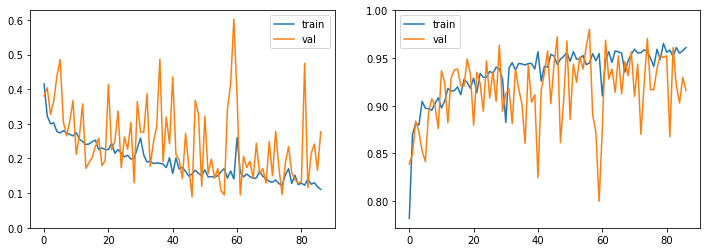

In [28]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6026 - accuracy: 0.6462 - precision: 0.8793 - recall: 0.6103 - f1: 0.7058 - specificity: 0.7570 - negative_predictive_value: 0.4172 - matthews_correlation_coefficient: 0.3305 - val_loss: 0.5395 - val_accuracy: 0.7329 - val_precision: 0.8231 - val_recall: 0.7575 - val_f1: 0.7867 - val_specificity: 0.6147 - val_negative_predictive_value: 0.4995 - val_matthews_correlation_coefficient: 0.3451

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.34509, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_29-04_54_49.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5800 - accuracy: 0.6707 - precision: 0.8865 - recall: 0.6394 - f1: 0.7363 - specificity: 0.7616 - negative_predictive_value: 0.4278 - matthews_correlation_coefficient: 0.3545 - val_loss: 0.6179 - val_accuracy: 0.6253 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5431 - accuracy: 0.6989 - precision: 0.8983 - recall: 0.6703 - f1: 0.7610 - specificity: 0.7832 - negative_predictive_value: 0.4573 - matthews_correlation_coefficient: 0.4001 - val_loss: 0.5326 - val_accuracy: 0.6817 - val_precision: 0.8501 - val_recall: 0.6471 - val_f1: 0.7307 - val_specificity: 0.7161 - val_negative_predictive_value: 0.4286 - val_matthews_correlation_coefficient: 0.3439

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.35937
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5390 - accuracy: 0.7048 - precision: 0.8934 - recall: 0.6730 - f1: 0.7621 - specificity: 0.7842 - negative_predictive_value: 0.4640 - matthews_correlation_coefficient: 0.4040 - val_loss: 0.5912 - val_accuracy: 0.6713 - val_precision: 0.8720 - val_recall: 0.6080 - val_f1: 0.7118 - val_specificity: 0.8083 - val_negative_predictive_value: 0.4506 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5263 - accuracy: 0.7089 - precision: 0.9021 - recall: 0.6736 - f1: 0.7655 - specificity: 0.7990 - negative_predictive_value: 0.4701 - matthews_correlation_coefficient: 0.4167 - val_loss: 0.5197 - val_accuracy: 0.7259 - val_precision: 0.8481 - val_recall: 0.7189 - val_f1: 0.7752 - val_specificity: 0.6700 - val_negative_predictive_value: 0.4722 - val_matthews_correlation_coefficient: 0.3788

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.38717
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5228 - accuracy: 0.7202 - precision: 0.9069 - recall: 0.6912 - f1: 0.7797 - specificity: 0.7943 - negative_predictive_value: 0.4770 - matthews_correlation_coefficient: 0.4314 - val_loss: 0.5333 - val_accuracy: 0.7077 - val_precision: 0.8523 - val_recall: 0.6847 - val_f1: 0.7564 - val_specificity: 0.7003 - val_negative_predictive_value: 0.4519 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5136 - accuracy: 0.7232 - precision: 0.8994 - recall: 0.6953 - f1: 0.7791 - specificity: 0.7851 - negative_predictive_value: 0.4801 - matthews_correlation_coefficient: 0.4248 - val_loss: 0.5542 - val_accuracy: 0.6748 - val_precision: 0.8629 - val_recall: 0.6266 - val_f1: 0.7213 - val_specificity: 0.7464 - val_negative_predictive_value: 0.4212 - val_matthews_correlation_coefficient: 0.3513

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.38717
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5137 - accuracy: 0.7202 - precision: 0.9109 - recall: 0.6902 - f1: 0.7809 - specificity: 0.8135 - negative_predictive_value: 0.4853 - matthews_correlation_coefficient: 0.4446 - val_loss: 0.5668 - val_accuracy: 0.6800 - val_precision: 0.8639 - val_recall: 0.6338 - val_f1: 0.7268 - val_specificity: 0.7465 - val_negative_predictive_value: 0.4257 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.38964
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5031 - accuracy: 0.7184 - precision: 0.9062 - recall: 0.6910 - f1: 0.7803 - specificity: 0.7806 - negative_predictive_value: 0.4680 - matthews_correlation_coefficient: 0.4194 - val_loss: 0.5403 - val_accuracy: 0.6938 - val_precision: 0.8599 - val_recall: 0.6577 - val_f1: 0.7413 - val_specificity: 0.7295 - val_negative_predictive_value: 0.4407 - val_matthews_correlation_coefficient: 0.3670

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.38964
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4993 - accuracy: 0.7187 - precision: 0.9148 - recall: 0.6848 - f1: 0.7787 - specificity: 0.8044 - negative_predictive_value: 0.4734 - matthews_correlation_coefficient: 0.4350 - val_loss: 0.5213 - val_accuracy: 0.7095 - val_precision: 0.8417 - val_recall: 0.7027 - val_f1: 0.7625 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.38964
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4932 - accuracy: 0.7304 - precision: 0.9079 - recall: 0.6979 - f1: 0.7841 - specificity: 0.8167 - negative_predictive_value: 0.4940 - matthews_correlation_coefficient: 0.4542 - val_loss: 0.6018 - val_accuracy: 0.6687 - val_precision: 0.8755 - val_recall: 0.6046 - val_f1: 0.7113 - val_specificity: 0.7854 - val_negative_predictive_value: 0.4168 - val_matthews_correlation_coefficient: 0.3635

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.38964
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4893 - accuracy: 0.7245 - precision: 0.9104 - recall: 0.6873 - f1: 0.7788 - specificity: 0.8125 - negative_predictive_value: 0.4813 - matthews_correlation_coefficient: 0.4477 - val_loss: 0.5054 - val_accuracy: 0.7173 - val_precision: 0.8557 - val_recall: 0.6948 - val_f1: 0.7641 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.39855
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4821 - accuracy: 0.7343 - precision: 0.9164 - recall: 0.7098 - f1: 0.7943 - specificity: 0.8153 - negative_predictive_value: 0.4988 - matthews_correlation_coefficient: 0.4644 - val_loss: 0.4850 - val_accuracy: 0.7346 - val_precision: 0.8562 - val_recall: 0.7226 - val_f1: 0.7808 - val_specificity: 0.6931 - val_negative_predictive_value: 0.4849 - val_matthews_correlation_coefficient: 0.4025

Epoch 00089: val_matthews_correlation_coefficient improved from 0.39855 to 0.40251, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_29-04_54_49.h5
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4811 - accuracy: 0.7332 - precision: 0.9181 - recall: 0.7042 - f1: 0.7922 - specificity: 0.8054 - negative_predictive_value: 0.4907 - matthews_correlation_coefficient: 0.4559 - val_loss: 0.5738 - v

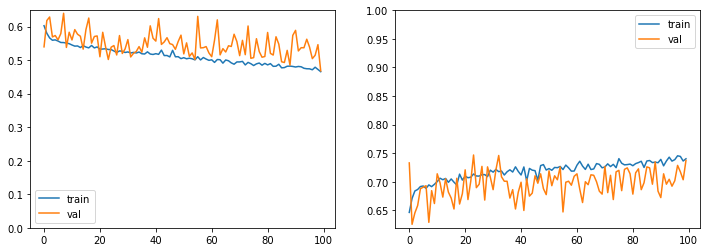

In [29]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4161 - accuracy: 0.7885 - precision: 0.9974 - recall: 0.7890 - f1: 0.8720 - specificity: 0.2828 - negative_predictive_value: 0.0558 - matthews_correlation_coefficient: 0.1038 - val_loss: 0.9273 - val_accuracy: 0.5768 - val_precision: 0.9988 - val_recall: 0.5842 - val_f1: 0.7313 - val_specificity: 0.2568 - val_negative_predictive_value: 0.0243 - val_matthews_correlation_coefficient: 0.0570

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.05696, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_29-05_09_47.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3115 - accuracy: 0.8295 - precision: 0.9988 - recall: 0.8298 - f1: 0.9032 - specificity: 0.2759 - negative_predictive_value: 0.0579 - matthews_correlation_coefficient: 0.1114 - val_loss: 0.1651 - val_accuracy: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2773 - accuracy: 0.8443 - precision: 0.9990 - recall: 0.8443 - f1: 0.9136 - specificity: 0.2839 - negative_predictive_value: 0.0633 - matthews_correlation_coefficient: 0.1187 - val_loss: 0.3452 - val_accuracy: 0.8465 - val_precision: 0.9990 - val_recall: 0.8498 - val_f1: 0.9169 - val_specificity: 0.2568 - val_negative_predictive_value: 0.0661 - val_matthews_correlation_coefficient: 0.1156

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.16126
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2633 - accuracy: 0.8586 - precision: 0.9990 - recall: 0.8587 - f1: 0.9226 - specificity: 0.2966 - negative_predictive_value: 0.0697 - matthews_correlation_coefficient: 0.1294 - val_loss: 0.2707 - val_accuracy: 0.8794 - val_precision: 0.9991 - val_recall: 0.8823 - val_f1: 0.9359 - val_specificity: 0.2568 - val_negative_predictive_value: 0.0932 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2573 - accuracy: 0.8638 - precision: 0.9993 - recall: 0.8637 - f1: 0.9257 - specificity: 0.3172 - negative_predictive_value: 0.0769 - matthews_correlation_coefficient: 0.1408 - val_loss: 0.2842 - val_accuracy: 0.8604 - val_precision: 0.9990 - val_recall: 0.8636 - val_f1: 0.9251 - val_specificity: 0.2568 - val_negative_predictive_value: 0.0735 - val_matthews_correlation_coefficient: 0.1239

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.16126
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2488 - accuracy: 0.8642 - precision: 0.9995 - recall: 0.8640 - f1: 0.9259 - specificity: 0.2862 - negative_predictive_value: 0.0800 - matthews_correlation_coefficient: 0.1370 - val_loss: 0.2568 - val_accuracy: 0.8768 - val_precision: 0.9991 - val_recall: 0.8799 - val_f1: 0.9345 - val_specificity: 0.2568 - val_negative_predictive_value: 0.0878 - val_matthews_correlation_coefficie

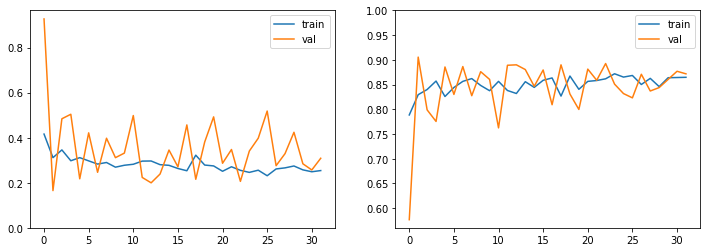

In [30]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [31]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [32]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_29-00_35_18.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_29-00_50_08.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_29-01_04_56.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_29-01_19_38.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_29-01_31_43.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_29-01_43_26.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_29-01_52_48.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_29-02_04_29.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_29-02_19_19.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_29-02_34_07.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_29-02_47_12.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_29-03_02_02.h5'
 '../models/autoencoders_requirements/shadows_behind_head_2020_03_29-03_13_14.h5'


In [33]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [34]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [35]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [36]:
import cv2
from glob import glob

# list_files = glob('../data/pybossa/images/*')
list_files = ['../data/pybossa/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images/AR_FDB_m-013-17.png
1 of 1


[array([[0.99999774]], dtype=float32),
 array([[0.87507546]], dtype=float32),
 array([[0.9917664]], dtype=float32),
 array([[0.97854185]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99928147]], dtype=float32),
 array([[0.7911662]], dtype=float32),
 array([[0.6375238]], dtype=float32),
 array([[0.68156224]], dtype=float32),
 array([[0.82131904]], dtype=float32),
 array([[0.97150266]], dtype=float32),
 array([[0.6598537]], dtype=float32),
 array([[0.99992764]], dtype=float32),
 array([[0.9947843]], dtype=float32),
 array([[0.9549063]], dtype=float32),
 array([[0.48999876]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.72498935]], dtype=float32),
 array([[0.9999745]], dtype=float32),
 array([[0.999801]], dtype=float32),
 array([[0.63497263]], dtype=float32),
 array([[0.99998736]], dtype=float32)]